# Data Prepare

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, Input, Flatten, Concatenate

In [ ]:
# GPU가 사용 가능한지 확인
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 첫 번째 GPU 메모리를 다 사용할 수 있도록 설정 (필요에 따라 조정 가능)
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is set to be used.")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")
else:
    print("No GPU found. Using CPU instead.")

No GPU found. Using CPU instead.


어라라... no_outlier_scailing으로 했는데, no_outlier로 해야하는지가 갑자기 헷갈림...
# Data 0~4

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# MinMaxScaler → StandardScaler : 데이터 범위를 먼저 제한하여 이상치의 영향을 줄임
#근데 보통 StandardScaler → MinMaxScaler 이거임.. transformer는 데이터가 -1:1, 0:1 일때 효과적임으로 일단은 이렇게...
# 아님 걍 minmax 하나만 사용하는 것이 더 나을수도
def preprocess_standardization(df, features, target):
    """
    데이터 전처리 함수 (MinMaxScaler + Standardization 추가)
    :param df: 데이터프레임
    :param features: 피처 리스트
    :param target: 타겟 리스트
    :return: 스케일링된 Train, Validation, Test 데이터셋
    """
    # 데이터프레임 인덱스 설정
    df.set_index('Date', inplace=True)

    # 입력 데이터와 타겟 데이터 분리
    x = df[features].values
    y = df[target].values

    # Train, Validation, Test 데이터 분할
    x_train = x[:3519]
    y_train = y[:3519]

    x_val = x[3519:4692]
    y_val = y[3519:4692]

    x_test = x[4692:]
    y_test = y[4692:]

    # MinMax 스케일링 객체 생성
    x_minmax_scaler, y_minmax_scaler = MinMaxScaler(), MinMaxScaler()

    # StandardScaler 객체 생성
    x_standard_scaler, y_standard_scaler = StandardScaler(), StandardScaler()

    # MinMaxScaler
    x_train_minmax = x_minmax_scaler.fit_transform(x_train)
    y_train_minmax = y_minmax_scaler.fit_transform(y_train.reshape(-1, 1))

    # MinMaxScaler + StandardScaler
    x_train_standard = x_standard_scaler.fit_transform(x_train_minmax)
    y_train_standard = y_standard_scaler.fit_transform(y_train_minmax)

    # 검증 및 테스트 데이터 변환 (fit 없이 transform만 수행)
    x_val_minmax = x_minmax_scaler.transform(x_val)
    y_val_minmax = y_minmax_scaler.transform(y_val.reshape(-1, 1))

    x_val_standard = x_standard_scaler.transform(x_val_minmax)
    y_val_standard = y_standard_scaler.transform(y_val_minmax)

    x_test_minmax = x_minmax_scaler.transform(x_test)
    y_test_minmax = y_minmax_scaler.transform(y_test.reshape(-1, 1))

    x_test_standard = x_standard_scaler.transform(x_test_minmax)
    y_test_standard = y_standard_scaler.transform(y_test_minmax)

    return (
        x_train_standard, y_train_standard,
        x_val_standard, y_val_standard,
        x_test_standard, y_test_standard,
        y_minmax_scaler, y_standard_scaler
    )


In [ ]:
features = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction','SE_Operating_Profit', 'SE_Net_Profit', 'SE_Total_Equity',
       'SE_Total_Liabilities', 'SE_Revenue', 'SE_Foreign', 'US_Inflation', 'KR_Inflation', 'CN_Inflation', 'US_GDP_Annual', 'KR_GDP_Annual',
       'CN_GDP_Annual', 'US_Economic_Growth_Rate', 'KR_Economic_Growth_Rate', 'US_Base', 'US_10', 'KR_Base', 'KR_10', 'WTI', 'Exchange', 'SOX_Close',
       'Phone', 'KR_Unemployment', 'Covid19', 'US_President_Republican', 'US_President_Democratic', 'KR_President_Democratic', 'KR_President_Conservative', 'KR_President_Neutral',
       'BB_High', 'BB_Low', 'RSI', 'Volume_Price_Ratio', 'Volume_Momentum', 'High_Low_Volatility', 'Lag_1', 'Lag_30', 'Lag_60', 'Lag_90']

features4_same = ['Lag_1', 'High_Low_Volatility', 'Volume_Momentum', 'Volume_Price_Ratio', 'RSI', 'BB_Low',
                  'SE_Foreign', 'Transaction', 'Open', 'High', 'Low', 'Volume', 'Change']
features4_int = ['Lag_60', 'Lag_1', 'High_Low_Volatility', 'Volume_Momentum', 'Volume_Price_Ratio', 'RSI',
                 'BB_Low', 'BB_High', 'SOX_Close', 'Exchange', 'KR_10', 'US_10', 'SE_Foreign', 'Transaction','Open', 'High', 'Low', 'Volume', 'Change']

#features4 = ['Open', 'High', 'Low', 'Volume', 'Change', 'Transaction', 'SE_Foreign', 'US_Inflation', 'KR_Inflation', 'CN_GDP_Annual',
#             'US_Economic_Growth_Rate', 'KR_Economic_Growth_Rate', 'KR_10', 'WTI', 'Exchange', 'SOX_Close', 'KR_Unemployment']
target = ['Close']

In [ ]:
### 3번 데이터  :  outlier 제거 전  + standard~
#/content/drive/MyDrive/same_no_outlier.csv
same3 = pd.read_csv('/content/drive/MyDrive/same_no_outlier_scaling.csv')
int3 = pd.read_csv('/content/drive/MyDrive/int_no_outlier_scaling.csv')
x_train_same3, y_train_same3, x_val_same3, y_val_same3, x_test_same3, y_test_same3, y_minmax_scaler_same, y_standard_scaler_same = preprocess_standardization(same3, features, target)
x_train_int3, y_train_int3, x_val_int3, y_val_int3, x_test_int3, y_test_int3, y_minmax_scaler_int, y_standard_scaler_int = preprocess_standardization(int3, features, target)

In [ ]:
### 4번 데이터 : 3번 데이터로 feature selection
same3 = pd.read_csv('/content/drive/MyDrive/same_no_outlier_scaling.csv')
int3 = pd.read_csv('/content/drive/MyDrive/int_no_outlier_scaling.csv')
x_train_same4, y_train_same4, x_val_same4, y_val_same4, x_test_same4, y_test_same4, y_minmax_scaler_same4, y_standard_scaler_same4 = preprocess_standardization(same3, features4_same, target)
x_train_int4, y_train_int4, x_val_int4, y_val_int4, x_test_int4, y_test_int4, y_minmax_scaler_int4, y_standard_scaler_int4 = preprocess_standardization(int3, features4_int, target)


# Transformer (다시 keras)

In [ ]:
from tensorflow.keras import layers, models

def create_sequences(data, target, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(x), np.array(y)

In [ ]:
'''# 포지셔널 인코딩 정의
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.pos_encoding = self._get_positional_encoding(sequence_length, d_model)

    def _get_positional_encoding(self, seq_len, d_model):
        angle_rads = self._get_angles(np.arange(seq_len)[:, np.newaxis],
                                      np.arange(d_model)[np.newaxis, :],
                                      d_model)
        # 짝수 인덱스에는 sin, 홀수 인덱스에는 cos 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def _get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 트랜스포머 블록 정의
def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.1):
    # 멀티헤드 어텐션
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)  # 잔차 연결

    # 피드포워드 네트워크
    ffn_output = layers.Dense(ff_dim, activation="relu")(out1)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)  # 잔차 연결

    return out2

# 트랜스포머 모델 정의
def build_transformer_model(input_shape, num_heads=2, key_dim=128, ff_dim=1192, num_blocks=2, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)

    # 포지셔널 인코딩 추가
    x = PositionalEncoding(sequence_length=input_shape[0], d_model=input_shape[1])(inputs)

    # 여러 개의 트랜스포머 블록 쌓기
    for _ in range(num_blocks):
        x = transformer_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout_rate=dropout_rate)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation="linear")(x)

    model = tf.keras.Model(inputs, outputs)
    return model


initial_learning_rate = 8.217112505860899e-05
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)


input_shape = (seq_length, x_train.shape[2])
model = build_transformer_model(input_shape)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()'''


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 5, 45)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding       │ (None, 5, 45)          │              0 │ input_layer[0][0]      │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 5, 45)          │         46,893 │ positional_encoding[0… │
│ (MultiHeadAttention)      │                        │                │ positional_encoding[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 5, 45)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 5, 45)          │              0 │ positional_encoding[0… │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 5, 45)          │             90 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 5, 1192)        │         54,832 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5, 45)          │         53,685 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 5, 45)          │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 5, 45)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 5, 45)          │             90 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 5, 45)          │         46,893 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 5, 45)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 5, 45)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 5, 45)          │             90 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 311,226 (1.19 MB)

 Trainable params: 311,226 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

#positional encoding :
class LearnablePositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.pos_encoding = self.add_weight( # 학습 가능한 포지셔널 인코딩 매트릭스 생성
            name="pos_encoding",  # 명시적으로 name 매개변수를 지정
            shape=(seq_len, d_model),  # shape 매개변수
            initializer="random_normal"  # 초기화 방법 지정
        )

    def call(self, inputs):
        return inputs + self.pos_encoding

# Local Attention : 입력 데이터의 일부 패치에만 어텐션 적용
def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.1):
    # Pre-Normalization: 잔차 연결 전에 LayerNormalization 적용
    attn_norm = layers.LayerNormalization(epsilon=1e-6)(inputs)
    # Local Multi-Head Attention: 특정 축(attention_axes=(1,))에 대해서만 어텐션 계산
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, attention_axes=(1,))(attn_norm, attn_norm)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    out1 = inputs + attn_output # Residual Connection

    # Feed-Forward Network (FFN)
    ffn_norm = layers.LayerNormalization(epsilon=1e-6)(out1)  # Pre-Normalization 적용
    # 첫 번째 Dense 레이어에서 GELU 활성화 함수 사용
    ffn_output = layers.Dense(ff_dim, activation="gelu")(ffn_norm)
    # 두 번째 Dense 레이어는 입력 크기와 동일한 출력 생성
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    # Residual Connection: 이전 출력과 FFN 출력을 더합니다.
    out2 = out1 + ffn_output

    return out2

# Transformer Model for Stock Price Prediction
def build_transformer_model(input_shape, num_heads=4, key_dim=64, ff_dim=128, num_blocks=3, dropout_rate=0.2):
    # 입력 데이터 정의
    inputs = layers.Input(shape=input_shape)

    # Learnable Positional Encoding 추가
    x = LearnablePositionalEncoding(seq_len=input_shape[0], d_model=input_shape[1])(inputs)

    # Stacking Transformer Blocks: 지정된 블록 개수만큼 반복
    for _ in range(num_blocks):
        x = transformer_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout_rate=dropout_rate)

    # Global Average Pooling: 시퀀스 전체 정보를 하나의 벡터로 요약
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output Layer (Regression): 회귀 문제를 위한 출력층 정의
    outputs = layers.Dense(1, activation="linear")(x)

    # 모델 생성
    model = tf.keras.Model(inputs, outputs)
    return model

# Example Usage
#input_shape = (60, 32)  # Example: 60 time steps, 32 features
#model = build_transformer_model(input_shape=input_shape, num_heads=4, key_dim=32, ff_dim=128, num_blocks=3, dropout_rate=0.2)
#model.summary()


In [ ]:
def train_model(x_train, y_train, x_val, y_val,
                num_heads=4, key_dim=64, ff_dim=128, num_blocks=2, dropout_rate=0.2, lr=0.001,
                initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.96, staircase=True,
                epochs=200, batch_size=32):

    lrs = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=staircase
    )

    input_shape = (seq_length, x_train.shape[2])
    model = build_transformer_model(input_shape, num_heads, key_dim, ff_dim, num_blocks, dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=["mae"])

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
    )
    return history, model

일단 동일한 조건으로 해보고...?

In [ ]:
def lossplot(history, figsize=(12, 4)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
same3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5865 entries, 2001-01-02 to 2024-09-30
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open                       5865 non-null   float64
 1   High                       5865 non-null   float64
 2   Low                        5865 non-null   float64
 3   Close                      5865 non-null   float64
 4   Volume                     5865 non-null   float64
 5   Change                     5865 non-null   float64
 6   Transaction                5865 non-null   float64
 7   SE_Operating_Profit        5865 non-null   float64
 8   SE_Net_Profit              5865 non-null   float64
 9   SE_Total_Equity            5865 non-null   float64
 10  SE_Total_Liabilities       5865 non-null   float64
 11  SE_Revenue                 5865 non-null   float64
 12  SE_Foreign                 5865 non-null   float64
 13  US_Inflation               5865 non-nu

In [ ]:
int_ddf = pd.read_csv('/content/drive/MyDrive/int_final.csv')
int_ddf['Date'] = pd.to_datetime(int_ddf['Date'])
dates = int_ddf['Date']
dates.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5865 entries, 0 to 5864
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
5865 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 45.9 KB


In [ ]:
same_ddf = pd.read_csv('/content/drive/MyDrive/same_final.csv')
same_ddf['Date'] = pd.to_datetime(same_ddf['Date'])
dates = same_ddf['Date']
dates.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5865 entries, 0 to 5864
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
5865 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 45.9 KB


In [ ]:
import matplotlib.dates as mdates

def predictplot(model, x_test, y_test, scaler, dates, figsize=(15, 6)):
    # 예측 수행
    y_pred = model.predict(x_test)

    # 스케일 복원
    y_test_actual = scaler.inverse_transform(y_test)
    y_pred_actual = scaler.inverse_transform(y_pred)

    # 오차 계산
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))


    # 평가 지표 출력
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    dates = dates.iloc[-len(y_test):]

    # 예측 결과 시각화
    plt.figure(figsize=figsize)
    plt.plot(dates, y_test_actual, label="Actual Price", color="b")
    plt.plot(dates, y_pred_actual, label="Predicted Price", color="r", alpha=0.7)
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

#outlier 제거 전 - same

In [ ]:
same3 = pd.read_csv('/content/drive/MyDrive/same_no_outlier_scaling.csv', parse_dates=['Date'])
int3 = pd.read_csv('/content/drive/MyDrive/int_no_outlier_scaling.csv', parse_dates=['Date'])

In [ ]:
x_train_standard, y_train_standard, x_val_standard, y_val_standard, x_test_standard, y_test_standard, y_minmax_scaler, y_standard_scaler = preprocess_standardization(
    same3, features, target
)

seq_length = 5
x_train, y_train = create_sequences(x_train_standard, y_train_standard, seq_length)
x_val, y_val = create_sequences(x_val_standard, y_val_standard, seq_length)
x_test, y_test = create_sequences(x_test_standard, y_test_standard, seq_length)


#1 :
num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False,
    epochs=100, batch_size=64



In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False,
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 19s - 340ms/step - loss: 1.0415 - mae: 0.7720 - val_loss: 3.3726 - val_mae: 1.4425
Epoch 2/100
55/55 - 9s - 155ms/step - loss: 0.3642 - mae: 0.4692 - val_loss: 2.9376 - val_mae: 1.2767
Epoch 3/100
55/55 - 10s - 190ms/step - loss: 0.2779 - mae: 0.3988 - val_loss: 2.3112 - val_mae: 1.0819
Epoch 4/100
55/55 - 9s - 159ms/step - loss: 0.2174 - mae: 0.3526 - val_loss: 2.4318 - val_mae: 1.0939
Epoch 5/100
55/55 - 9s - 162ms/step - loss: 0.1822 - mae: 0.3242 - val_loss: 2.3260 - val_mae: 1.0754
Epoch 6/100
55/55 - 13s - 238ms/step - loss: 0.1614 - mae: 0.3065 - val_loss: 1.9712 - val_mae: 0.9292
Epoch 7/100
55/55 - 17s - 302ms/step - loss: 0.1363 - mae: 0.2813 - val_loss: 1.8759 - val_mae: 0.9041
Epoch 8/100
55/55 - 13s - 245ms/step - loss: 0.1266 - mae: 0.2719 - val_loss: 1.6141 - val_mae: 0.7874
Epoch 9/100
55/55 - 9s - 163ms/step - loss: 0.1038 - mae: 0.2483 - val_loss: 1.7048 - val_mae: 0.8470
Epoch 10/100
55/55 - 6s - 109ms/step - loss: 0.0997 - mae: 0.2408 - val_loss:

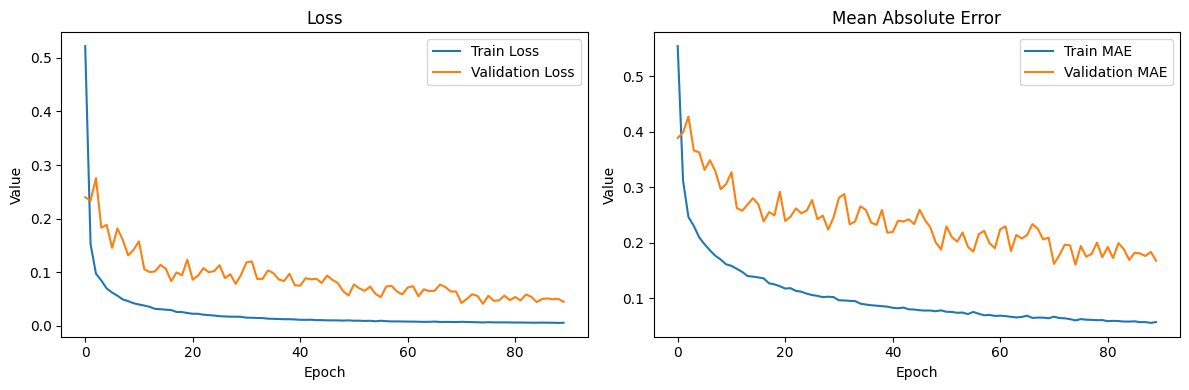

In [ ]:
#lossplot(history) #이게 standard 전

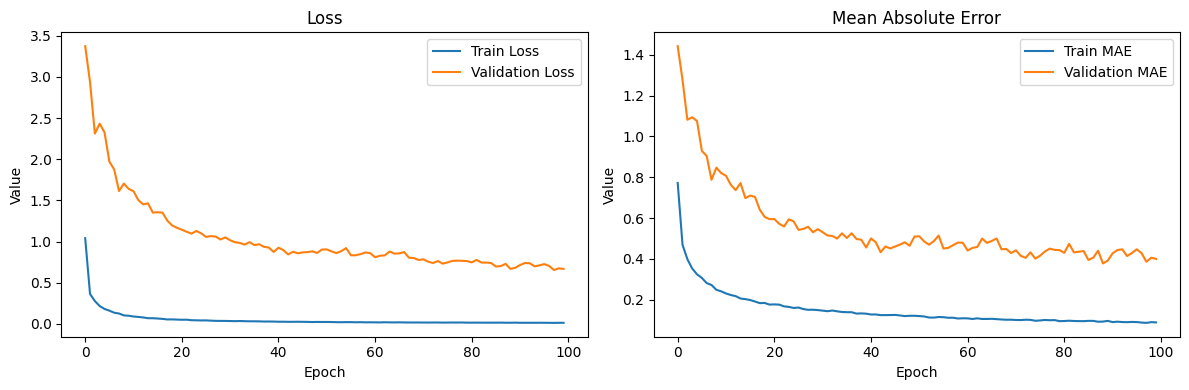

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Absolute Error (MAE): 0.96799906663532
Root Mean Squared Error (RMSE): 0.9805846660708405


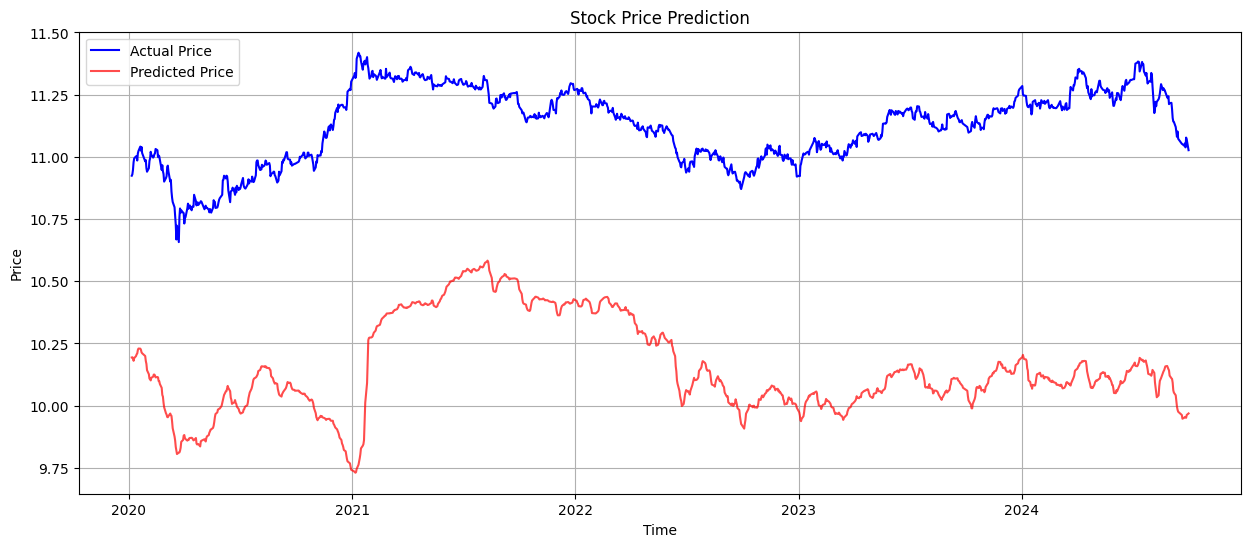

In [ ]:
#predictplot(model, x_test, y_test, y_scaler, dates) #이게 standard 전

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Mean Absolute Error (MAE): 4.12961022308829
Root Mean Squared Error (RMSE): 4.349263962214237


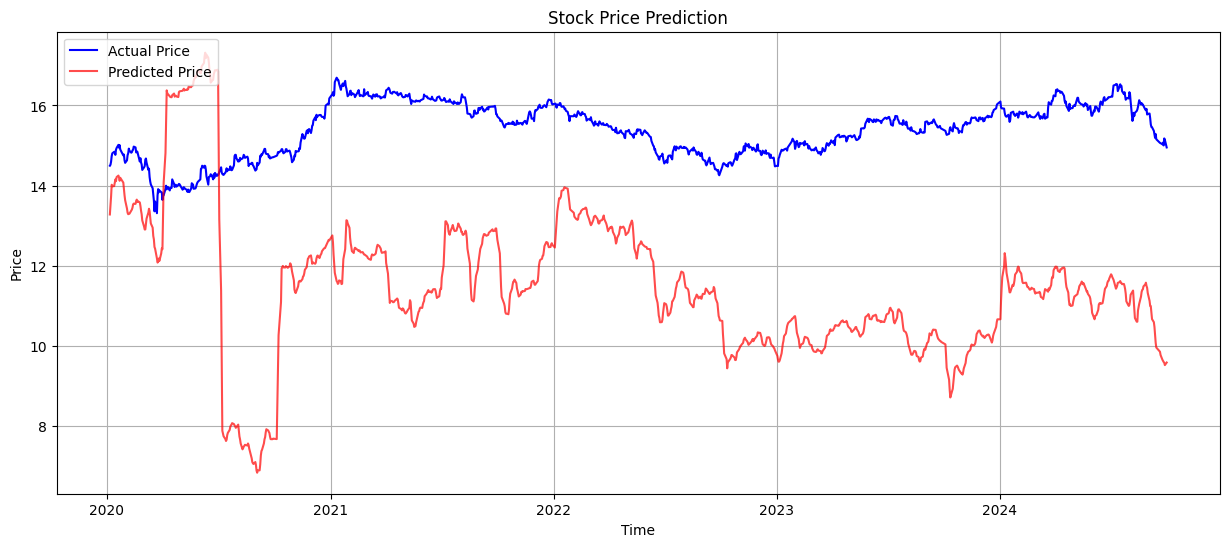

In [ ]:
#predictplot(model, x_test, y_test, y_scaler, dates) #대체적으로 값은 비슷해졌는데, 상승과 하락에 예민해지는 듯
predictplot(model, x_test, y_test, y_minmax_scaler, dates)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mean Absolute Error (MAE): 0.3843756687339164
Root Mean Squared Error (RMSE): 0.4048205885203635


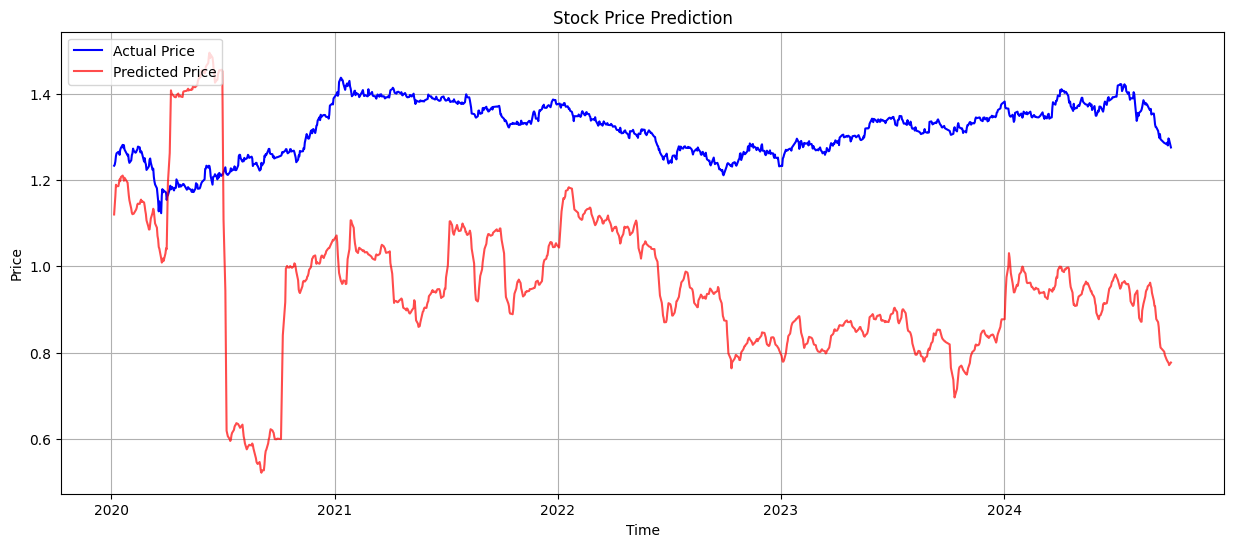

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

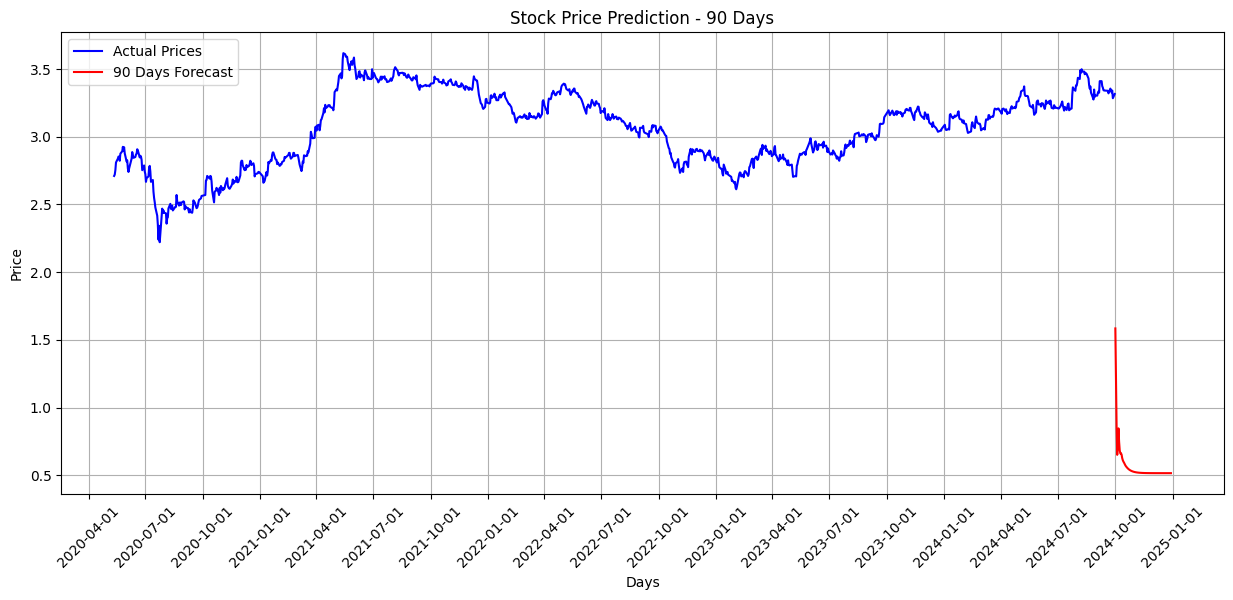

In [ ]:
def predict_future(model, x_test, steps=90):
    """
    미래 예측 수행
    :param model: 학습된 모델
    :param x_test: 테스트 데이터
    :param steps: 예측할 미래의 일수
    :return: 미래 예측값 리스트
    """
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 시퀀스 가져오기

    for i in range(steps):
        # 모델 예측 수행
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # 입력 시퀀스를 업데이트 (shift and append prediction)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1] = prediction

    return np.array(future_predictions)


# y_test를 1D로 변환
y_test = y_test.ravel()

# test_dates 길이를 y_test와 정확히 맞춤
test_dates = same_ddf['Date'][4782:] #same3 이 아니고
test_dates = test_dates[-len(y_test):]  # y_test 길이에 맞춰 슬라이싱

# 미래 날짜 생성
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)

# 미래 예측값 생성
future_90_days = predict_future(model, x_test, steps=90)

# 시각화
plt.figure(figsize=(15, 6))

# 실제 가격 플롯
plt.plot(test_dates, y_test[:len(test_dates)], label='Actual Prices', color='blue')

# 90일 예측 플롯
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')

# 플롯 설정
plt.title('Stock Price Prediction - 90 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')

# 날짜 포맷팅 및 틱 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

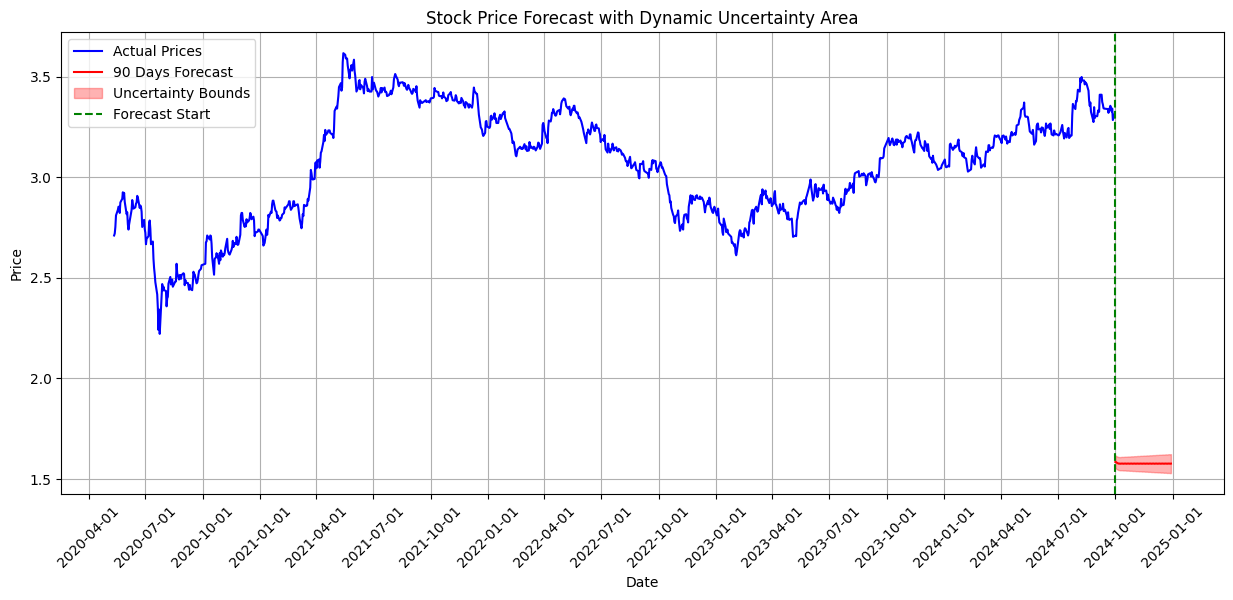

In [ ]:
def predict_future_with_bounds(model, x_test, steps=90):
    """
    미래 예측 수행 및 상한/하한 계산
    :param model: 학습된 모델
    :param x_test: 테스트 데이터
    :param steps: 예측할 미래의 일수
    :return: 미래 예측값, 상한, 하한
    """
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]  # 마지막 시퀀스 가져오기

    for i in range(steps):
        # 모델 예측 수행
        prediction = model.predict(current_input)[0, 0]

        # 불확실성 계산
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 증가

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        # 현재 입력 업데이트 (shift and append prediction)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return (
        np.array(future_predictions),
        np.array(upper_bounds),
        np.array(lower_bounds),
    )


# 테스트 날짜와 y_test 길이 맞춤
test_dates = same_ddf['Date'][4782:]
y_test = y_test.ravel()
test_dates = test_dates[-len(y_test):]

# 미래 날짜 생성
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)

# 90일 미래 예측 수행
future_90_days, upper_90_days, lower_90_days = predict_future_with_bounds(model, x_test, steps=90)

# 시각화
plt.figure(figsize=(15, 6))

# 실제 주식 가격
plt.plot(test_dates, y_test[:len(test_dates)], label="Actual Prices", color="blue")

# 90일 예측 및 불확실성 영역
plt.plot(future_dates, future_90_days, label="90 Days Forecast", color="red")
plt.fill_between(
    future_dates,
    upper_90_days,
    lower_90_days,
    color="red",
    alpha=0.3,
    label="Uncertainty Bounds",
)

# 예측 시작점 표시
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color="green", linestyle="--", label="Forecast Start")

# 플롯 설정
plt.title("Stock Price Forecast with Dynamic Uncertainty Area")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

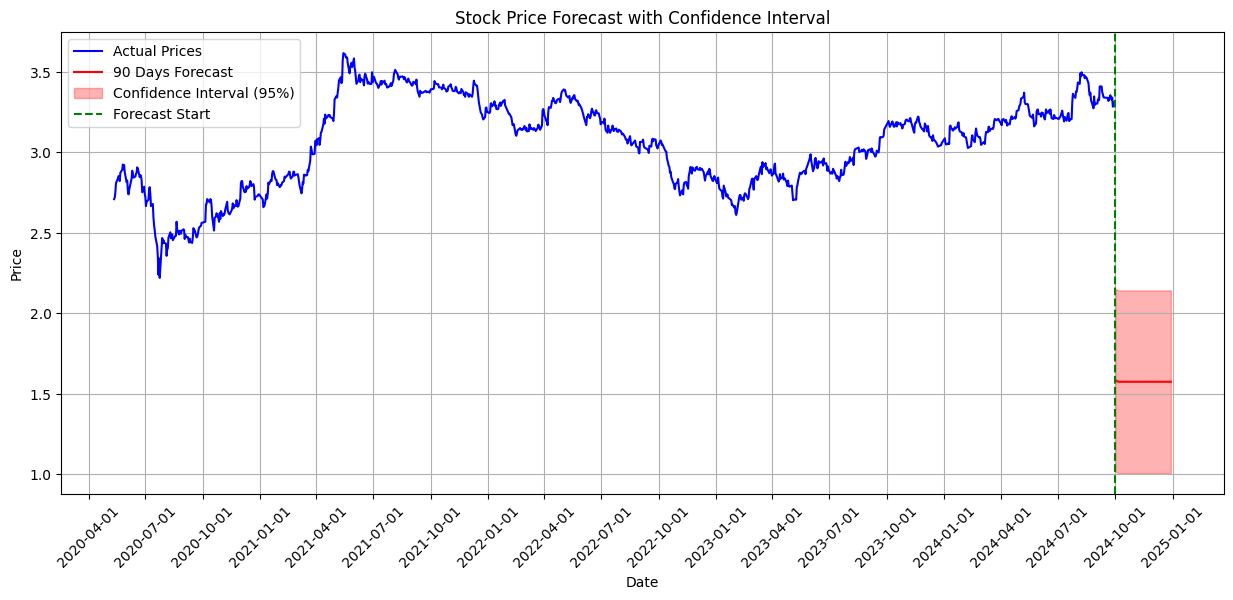

In [ ]:
def predict_future_with_confidence(model, x_test, steps=90):
    """
    미래 예측 수행 및 Confidence Interval 계산
    :param model: 학습된 모델
    :param x_test: 테스트 데이터
    :param steps: 예측할 미래의 일수
    :return: 미래 예측값, 상한선, 하한선
    """
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 시퀀스를 가져옵니다

    # 초기 변동성 계산 (기존 데이터의 표준편차 사용)
    std = np.std(x_test[:, :, -1])

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # 입력 시퀀스 업데이트 (shift and append prediction)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    # Confidence Interval 계산 (95% 신뢰구간)
    future_predictions = np.array(future_predictions)
    upper_bound = future_predictions + 1.96 * std
    lower_bound = future_predictions - 1.96 * std

    return future_predictions, upper_bound, lower_bound


# 테스트 날짜와 y_test 길이 맞춤
test_dates = same_ddf['Date'][4782:]
y_test = y_test.ravel()
test_dates = test_dates[-len(y_test):]

# 미래 날짜 생성
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)

# 미래 예측 수행
future_90_days, upper_90_days, lower_90_days = predict_future_with_confidence(model, x_test, steps=90)

# 시각화
plt.figure(figsize=(15, 6))

# 실제 가격
plt.plot(test_dates, y_test[:len(test_dates)], label="Actual Prices", color="blue")

# 예측값과 Confidence Interval
plt.plot(future_dates, future_90_days, label="90 Days Forecast", color="red")
plt.fill_between(
    future_dates,
    upper_90_days,
    lower_90_days,
    color="red",
    alpha=0.3,
    label="Confidence Interval (95%)",
)

# 예측 시작점 표시
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color="green", linestyle="--", label="Forecast Start")

# 플롯 설정
plt.title("Stock Price Forecast with Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

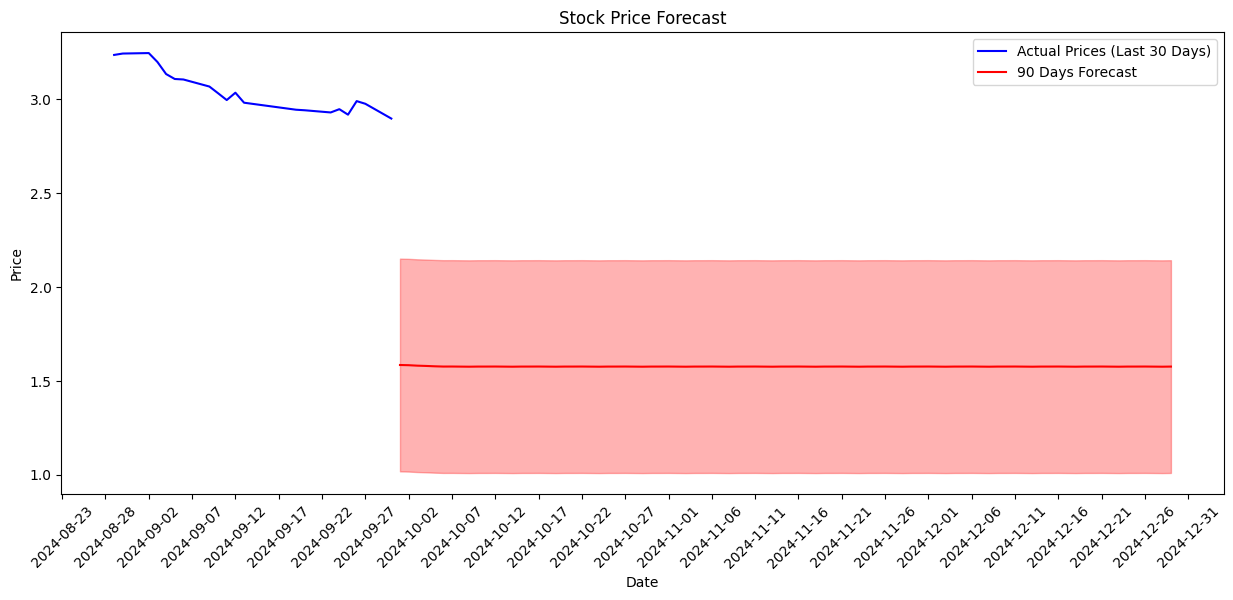

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
#plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

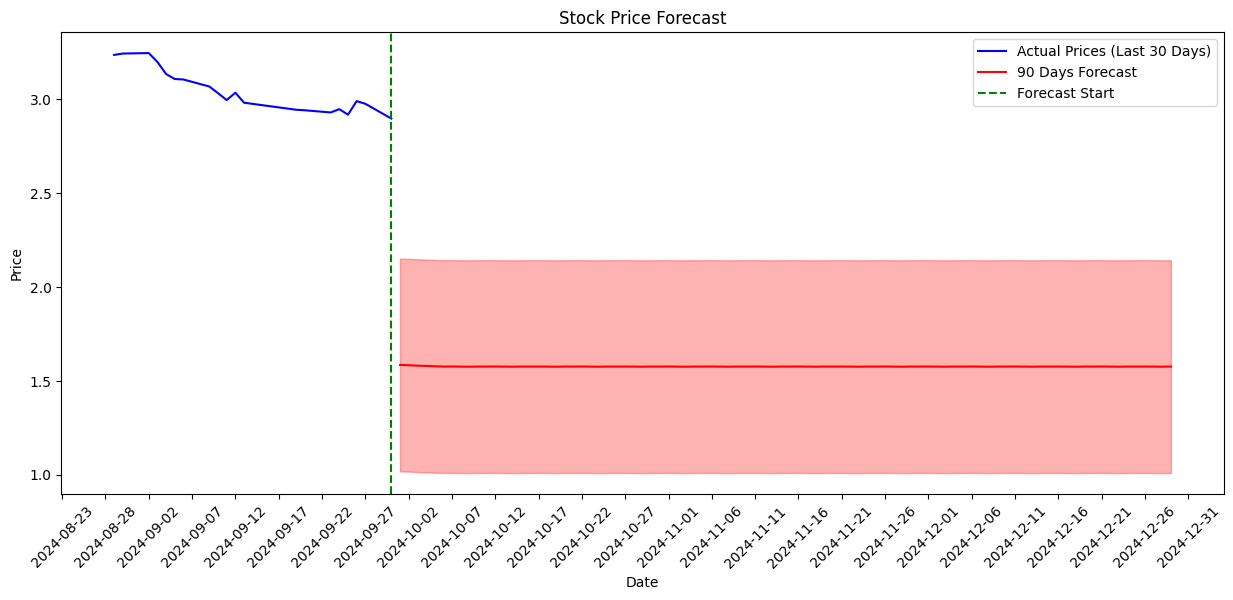

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound

future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()



---



In [ ]:
path= r'/content/drive/MyDrive/Colab Notebooks/Transformer_model_path'
# model.save_weights(path+ 'standard_same_')

# 2
num_heads=8, key_dim=64, ff_dim=256, num_blocks=3, dropout_rate=0.3,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=64, ff_dim=256, num_blocks=3, dropout_rate=0.3,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
) #20분

Epoch 1/100
55/55 - 29s - 522ms/step - loss: 1.4218 - mae: 0.8379 - val_loss: 9.0294 - val_mae: 1.8484
Epoch 2/100
55/55 - 8s - 137ms/step - loss: 0.2915 - mae: 0.4209 - val_loss: 7.5707 - val_mae: 1.6306
Epoch 3/100
55/55 - 10s - 179ms/step - loss: 0.1792 - mae: 0.3320 - val_loss: 7.1187 - val_mae: 1.5851
Epoch 4/100
55/55 - 12s - 227ms/step - loss: 0.1379 - mae: 0.2920 - val_loss: 6.2948 - val_mae: 1.4666
Epoch 5/100
55/55 - 10s - 190ms/step - loss: 0.1084 - mae: 0.2578 - val_loss: 5.9543 - val_mae: 1.3909
Epoch 6/100
55/55 - 13s - 232ms/step - loss: 0.0937 - mae: 0.2397 - val_loss: 5.5904 - val_mae: 1.3468
Epoch 7/100
55/55 - 16s - 292ms/step - loss: 0.0860 - mae: 0.2306 - val_loss: 5.3407 - val_mae: 1.3201
Epoch 8/100
55/55 - 10s - 184ms/step - loss: 0.0654 - mae: 0.2025 - val_loss: 5.1394 - val_mae: 1.2966
Epoch 9/100
55/55 - 11s - 201ms/step - loss: 0.0644 - mae: 0.1978 - val_loss: 4.7987 - val_mae: 1.2305
Epoch 10/100
55/55 - 20s - 365ms/step - loss: 0.0601 - mae: 0.1911 - val_l

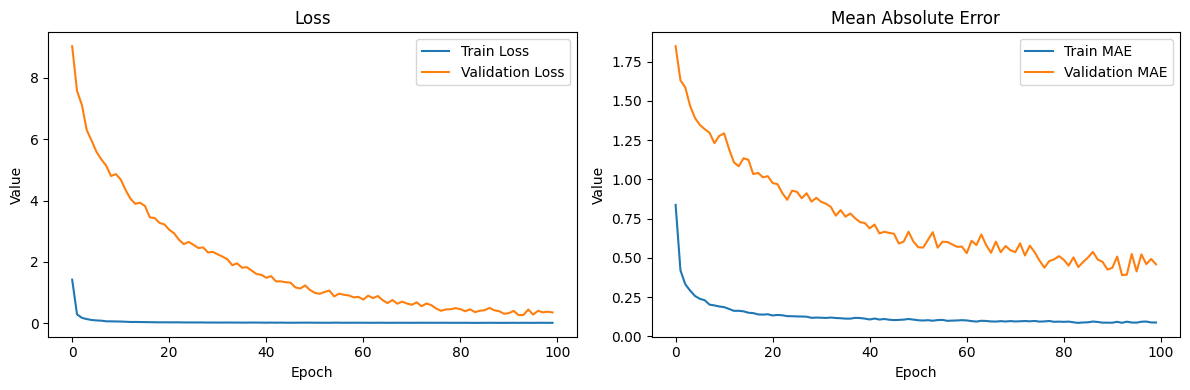

In [ ]:
lossplot(history)

In [ ]:
def predictplot(model, x_test, y_test, scaler, dates, figsize=(15, 6)):
    # 예측 수행
    y_pred = model.predict(x_test)

    # 스케일 복원: 1D 배열을 2D로 변환 후 복원
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # 평가 지표 계산
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

    # 평가 지표 출력
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # dates 길이 조정
    dates = dates.iloc[-len(y_test):]

    # 시각화
    plt.figure(figsize=figsize)
    plt.plot(dates, y_test_actual, label="Actual Price", color="b")
    plt.plot(dates, y_pred_actual, label="Predicted Price", color="r", alpha=0.7)
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Mean Absolute Error (MAE): 0.3551139279562604
Root Mean Squared Error (RMSE): 0.3563328267175834


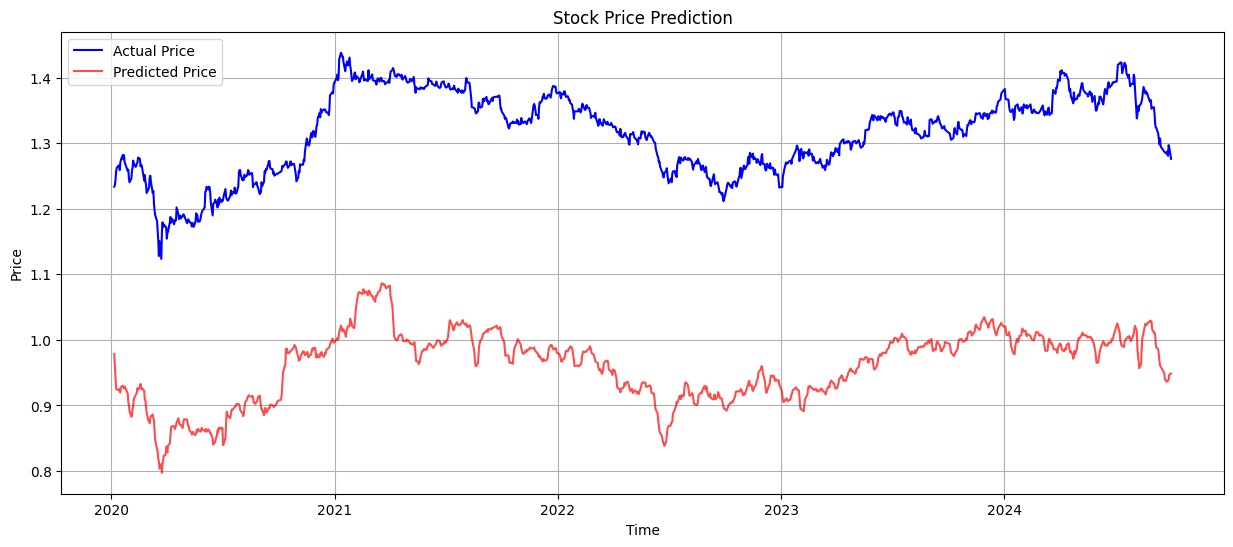

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

# 3
num_heads=8, key_dim=64, ff_dim=256, num_blocks=4, dropout_rate=0.2, lr=0.001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=64, ff_dim=256, num_blocks=4, dropout_rate=0.2, lr=0.001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
) #4분

Epoch 1/100
55/55 - 70s - 1s/step - loss: 1.1725 - mae: 0.7109 - val_loss: 0.5201 - val_mae: 0.5478
Epoch 2/100
55/55 - 10s - 190ms/step - loss: 0.1823 - mae: 0.3332 - val_loss: 1.0689 - val_mae: 0.8374
Epoch 3/100
55/55 - 10s - 180ms/step - loss: 0.1176 - mae: 0.2717 - val_loss: 0.7158 - val_mae: 0.6587
Epoch 4/100
55/55 - 8s - 149ms/step - loss: 0.0957 - mae: 0.2412 - val_loss: 1.0556 - val_mae: 0.8018
Epoch 5/100
55/55 - 13s - 229ms/step - loss: 0.0756 - mae: 0.2162 - val_loss: 1.1493 - val_mae: 0.8538
Epoch 6/100
55/55 - 19s - 342ms/step - loss: 0.0625 - mae: 0.1968 - val_loss: 1.1268 - val_mae: 0.8705
Epoch 7/100
55/55 - 10s - 184ms/step - loss: 0.0542 - mae: 0.1828 - val_loss: 0.9839 - val_mae: 0.7682
Epoch 8/100
55/55 - 12s - 220ms/step - loss: 0.0504 - mae: 0.1754 - val_loss: 1.1885 - val_mae: 0.8755
Epoch 9/100
55/55 - 10s - 173ms/step - loss: 0.0428 - mae: 0.1634 - val_loss: 0.9341 - val_mae: 0.7529
Epoch 10/100
55/55 - 9s - 161ms/step - loss: 0.0379 - mae: 0.1517 - val_loss:

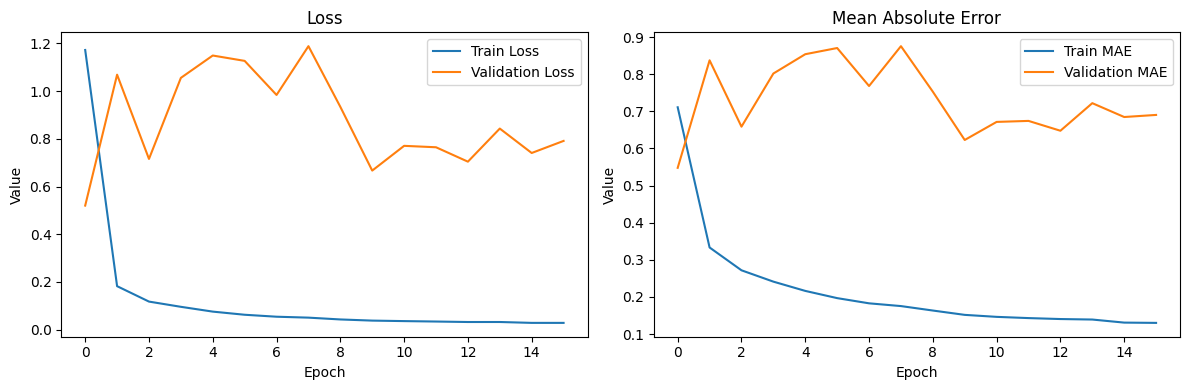

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Mean Absolute Error (MAE): 0.3187915675827373
Root Mean Squared Error (RMSE): 0.32605172985054287


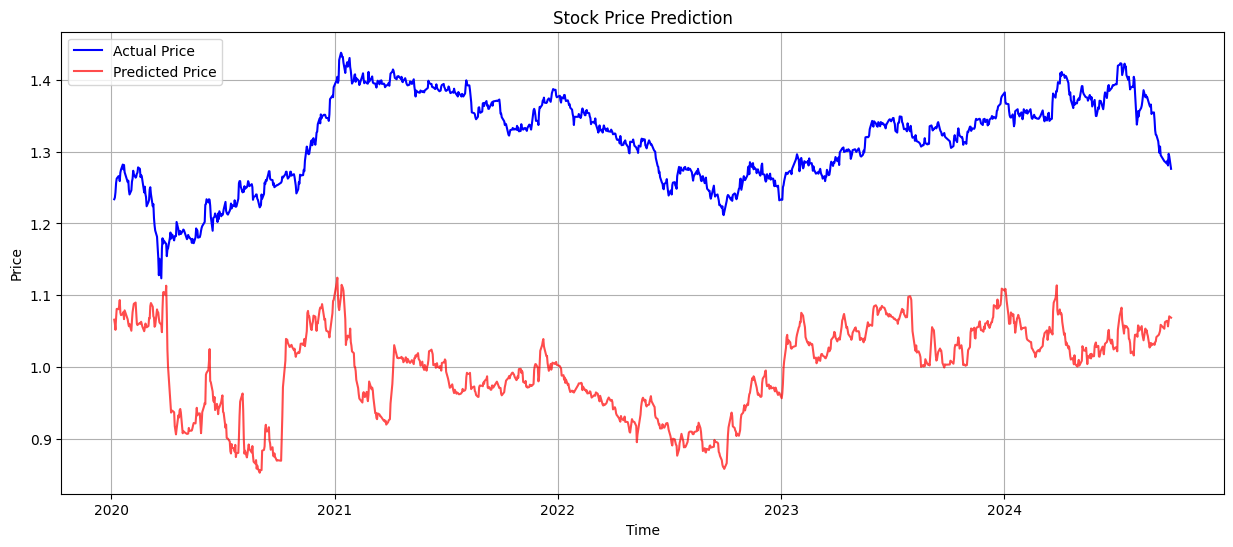

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

# 4
num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.1, lr=0.0005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.1, lr=0.0005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
) #15

Epoch 1/100
55/55 - 18s - 329ms/step - loss: 0.8323 - mae: 0.5986 - val_loss: 3.6726 - val_mae: 0.8225
Epoch 2/100
55/55 - 12s - 211ms/step - loss: 0.1375 - mae: 0.2850 - val_loss: 3.5802 - val_mae: 0.7654
Epoch 3/100
55/55 - 6s - 110ms/step - loss: 0.0874 - mae: 0.2248 - val_loss: 3.4524 - val_mae: 0.6665
Epoch 4/100
55/55 - 11s - 208ms/step - loss: 0.0670 - mae: 0.1996 - val_loss: 3.4454 - val_mae: 0.6656
Epoch 5/100
55/55 - 12s - 216ms/step - loss: 0.0552 - mae: 0.1824 - val_loss: 3.4317 - val_mae: 0.6601
Epoch 6/100
55/55 - 7s - 132ms/step - loss: 0.0461 - mae: 0.1678 - val_loss: 3.4544 - val_mae: 0.6923
Epoch 7/100
55/55 - 11s - 202ms/step - loss: 0.0409 - mae: 0.1545 - val_loss: 3.4466 - val_mae: 0.6956
Epoch 8/100
55/55 - 7s - 130ms/step - loss: 0.0356 - mae: 0.1462 - val_loss: 3.3820 - val_mae: 0.6636
Epoch 9/100
55/55 - 8s - 139ms/step - loss: 0.0338 - mae: 0.1414 - val_loss: 3.3629 - val_mae: 0.6488
Epoch 10/100
55/55 - 11s - 196ms/step - loss: 0.0284 - mae: 0.1305 - val_loss

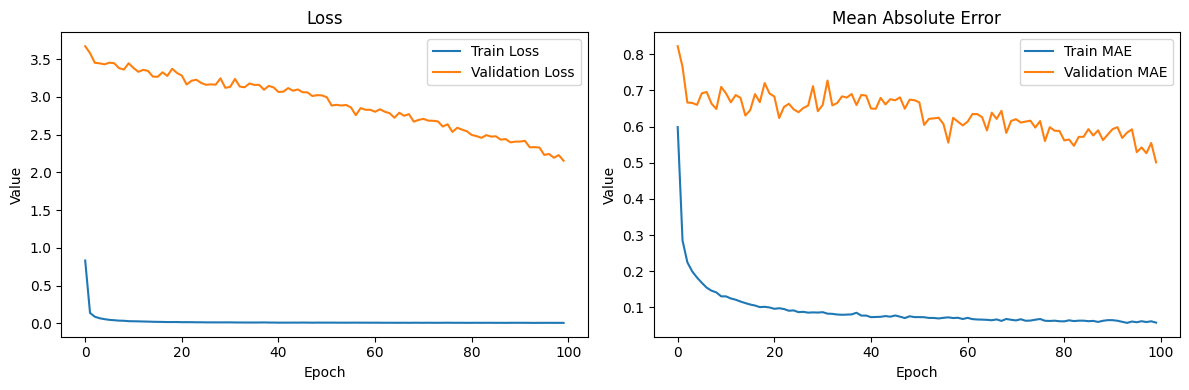

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Mean Absolute Error (MAE): 0.33214383012785914
Root Mean Squared Error (RMSE): 0.3393856522122697


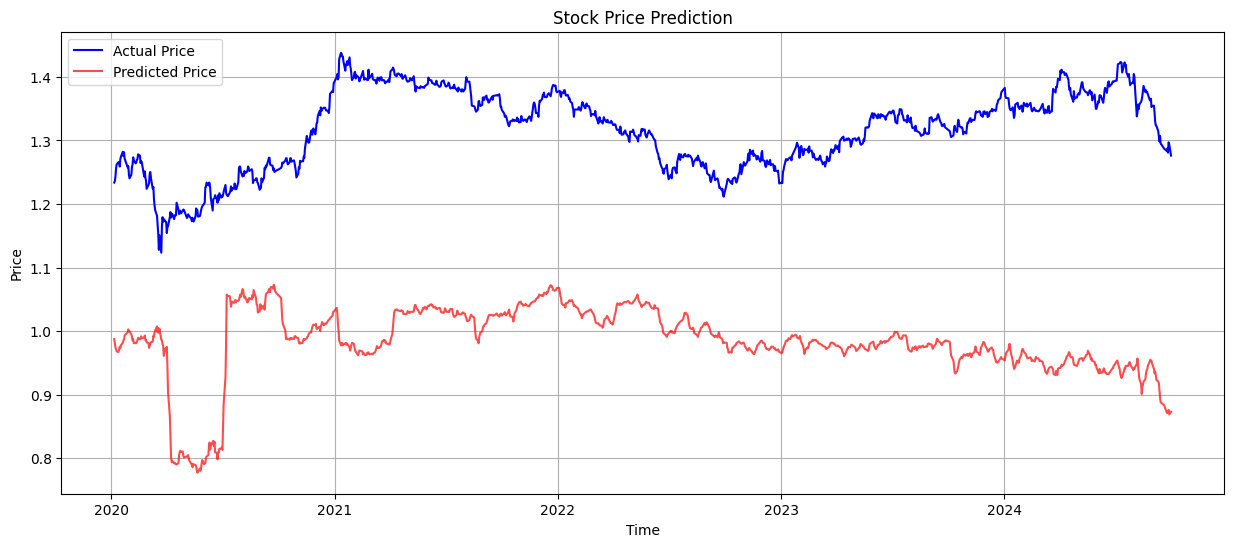

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

# 5
num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, epochs=100, batch_size=64
  

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 21s - 373ms/step - loss: 1.0758 - mae: 0.7769 - val_loss: 11.0406 - val_mae: 2.2324
Epoch 2/100
55/55 - 8s - 140ms/step - loss: 0.4852 - mae: 0.5383 - val_loss: 9.3943 - val_mae: 2.0108
Epoch 3/100
55/55 - 11s - 203ms/step - loss: 0.3614 - mae: 0.4575 - val_loss: 9.0186 - val_mae: 2.0002
Epoch 4/100
55/55 - 12s - 213ms/step - loss: 0.2710 - mae: 0.3969 - val_loss: 8.6242 - val_mae: 1.9131
Epoch 5/100
55/55 - 8s - 143ms/step - loss: 0.2312 - mae: 0.3661 - val_loss: 8.3615 - val_mae: 1.9223
Epoch 6/100
55/55 - 10s - 189ms/step - loss: 0.2001 - mae: 0.3416 - val_loss: 7.5904 - val_mae: 1.7848
Epoch 7/100
55/55 - 13s - 228ms/step - loss: 0.1705 - mae: 0.3174 - val_loss: 6.9215 - val_mae: 1.6750
Epoch 8/100
55/55 - 8s - 147ms/step - loss: 0.1607 - mae: 0.3074 - val_loss: 6.5392 - val_mae: 1.6333
Epoch 9/100
55/55 - 8s - 145ms/step - loss: 0.1285 - mae: 0.2807 - val_loss: 6.6591 - val_mae: 1.6681
Epoch 10/100
55/55 - 9s - 168ms/step - loss: 0.1268 - mae: 0.2735 - val_loss

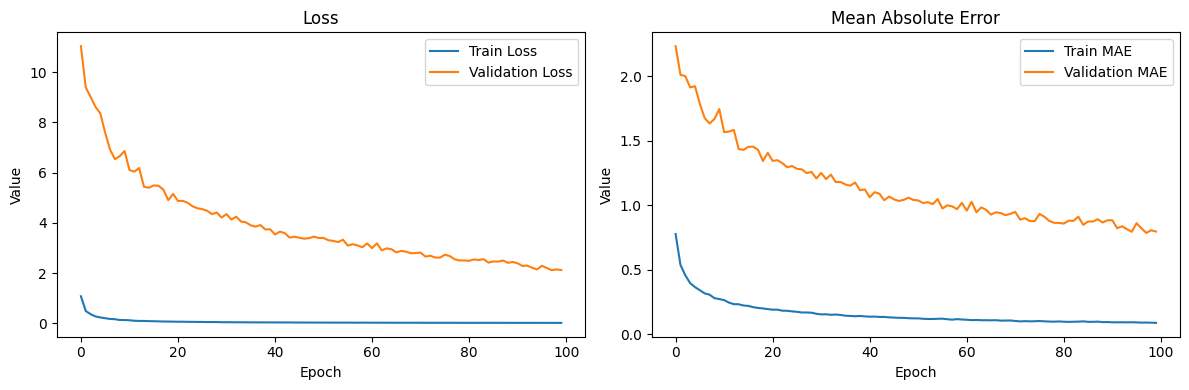

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Absolute Error (MAE): 0.6686470955789376
Root Mean Squared Error (RMSE): 0.6791392275184001


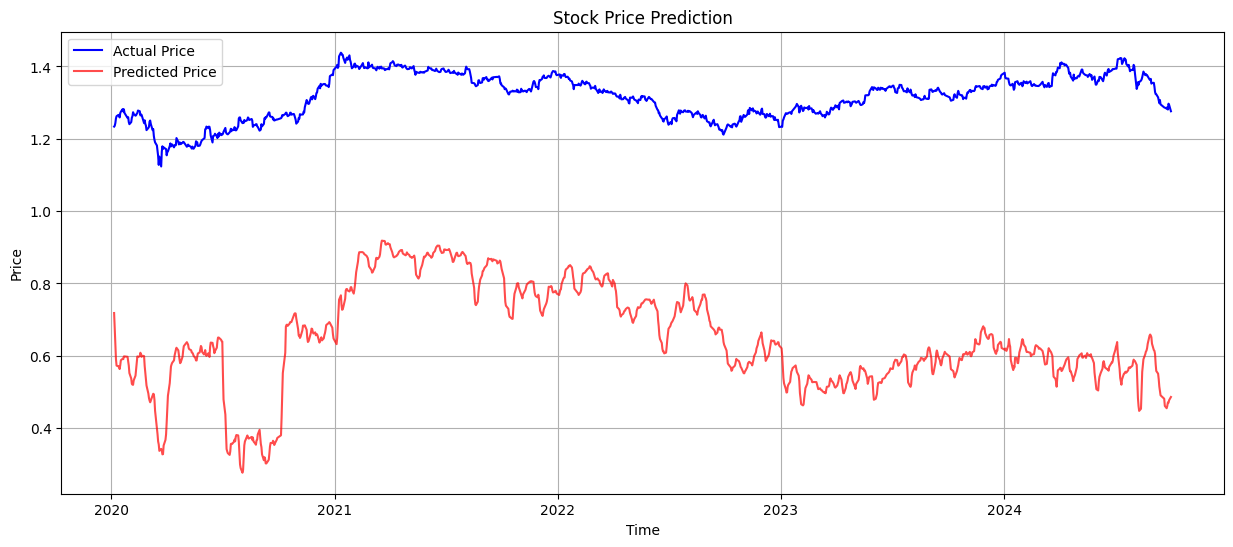

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

# 6
num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, epochs=100, batch_size=64

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 19s - 345ms/step - loss: 1.4681 - mae: 0.9109 - val_loss: 10.8347 - val_mae: 2.4927
Epoch 2/100
55/55 - 8s - 152ms/step - loss: 0.5294 - mae: 0.5684 - val_loss: 11.1419 - val_mae: 2.4932
Epoch 3/100
55/55 - 6s - 108ms/step - loss: 0.3826 - mae: 0.4776 - val_loss: 10.0636 - val_mae: 2.3740
Epoch 4/100
55/55 - 11s - 204ms/step - loss: 0.3105 - mae: 0.4319 - val_loss: 9.2480 - val_mae: 2.2704
Epoch 5/100
55/55 - 11s - 205ms/step - loss: 0.2575 - mae: 0.3885 - val_loss: 8.8927 - val_mae: 2.2389
Epoch 6/100
55/55 - 8s - 148ms/step - loss: 0.2249 - mae: 0.3614 - val_loss: 7.5804 - val_mae: 2.0335
Epoch 7/100
55/55 - 10s - 186ms/step - loss: 0.1986 - mae: 0.3446 - val_loss: 7.1079 - val_mae: 1.9727
Epoch 8/100
55/55 - 8s - 146ms/step - loss: 0.1681 - mae: 0.3166 - val_loss: 6.7273 - val_mae: 1.9247
Epoch 9/100
55/55 - 6s - 111ms/step - loss: 0.1573 - mae: 0.3043 - val_loss: 6.2782 - val_mae: 1.8524
Epoch 10/100
55/55 - 12s - 224ms/step - loss: 0.1421 - mae: 0.2914 - val_lo

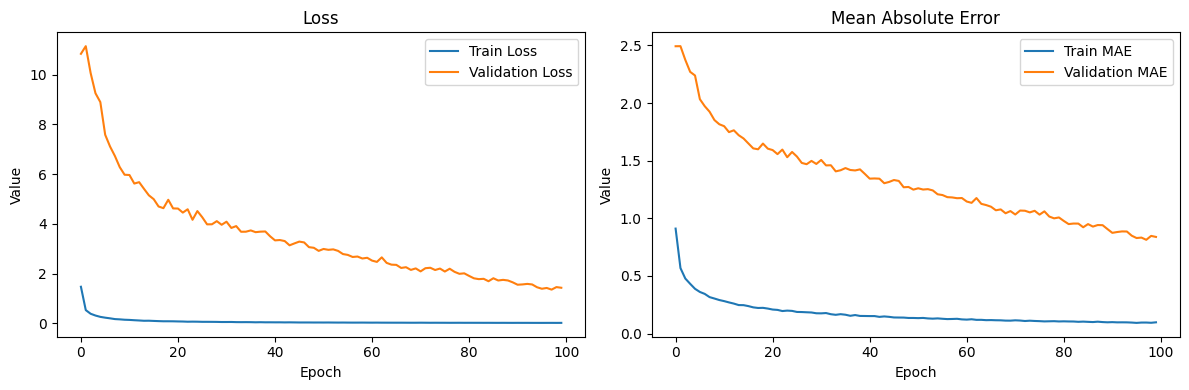

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Mean Absolute Error (MAE): 0.48615679409461904
Root Mean Squared Error (RMSE): 0.5387463064604958


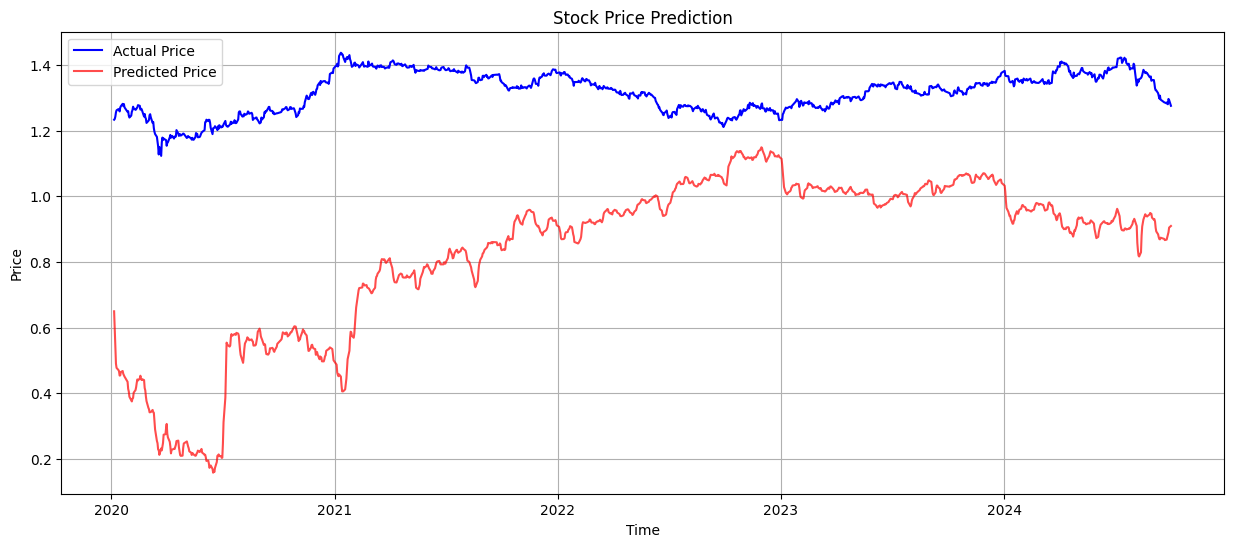

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

# 7
num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.00005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, epochs=100, batch_size=64

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.00005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 18s - 330ms/step - loss: 1.1897 - mae: 0.8324 - val_loss: 0.6181 - val_mae: 0.4638
Epoch 2/100
55/55 - 6s - 107ms/step - loss: 0.6284 - mae: 0.6133 - val_loss: 0.6383 - val_mae: 0.4735
Epoch 3/100
55/55 - 10s - 187ms/step - loss: 0.4712 - mae: 0.5311 - val_loss: 0.5841 - val_mae: 0.4283
Epoch 4/100
55/55 - 8s - 140ms/step - loss: 0.3902 - mae: 0.4858 - val_loss: 0.5712 - val_mae: 0.4172
Epoch 5/100
55/55 - 8s - 153ms/step - loss: 0.3081 - mae: 0.4327 - val_loss: 0.5600 - val_mae: 0.3976
Epoch 6/100
55/55 - 11s - 192ms/step - loss: 0.3040 - mae: 0.4213 - val_loss: 0.4920 - val_mae: 0.3386
Epoch 7/100
55/55 - 12s - 222ms/step - loss: 0.2536 - mae: 0.3836 - val_loss: 0.4965 - val_mae: 0.3421
Epoch 8/100
55/55 - 6s - 106ms/step - loss: 0.2218 - mae: 0.3613 - val_loss: 0.4774 - val_mae: 0.3307
Epoch 9/100
55/55 - 11s - 201ms/step - loss: 0.2094 - mae: 0.3504 - val_loss: 0.4556 - val_mae: 0.3082
Epoch 10/100
55/55 - 12s - 212ms/step - loss: 0.1878 - mae: 0.3306 - val_loss

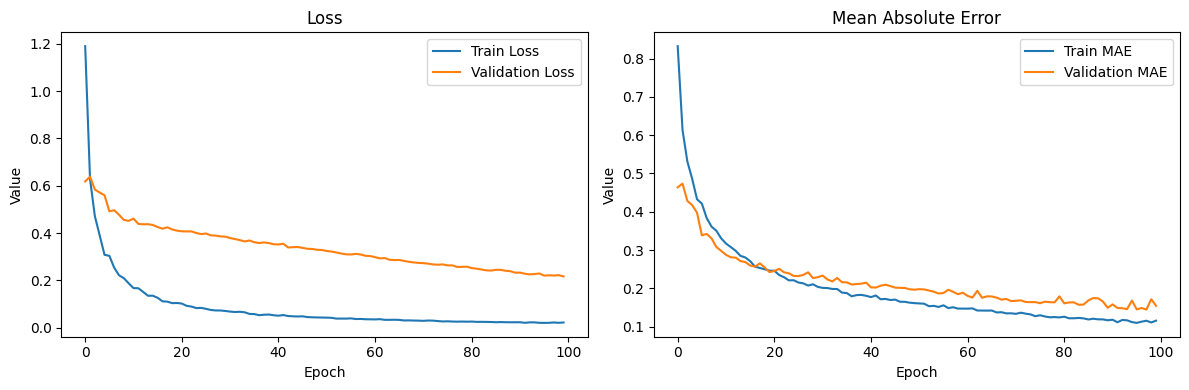

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Mean Absolute Error (MAE): 0.12751262411981557
Root Mean Squared Error (RMSE): 0.16715145610696816


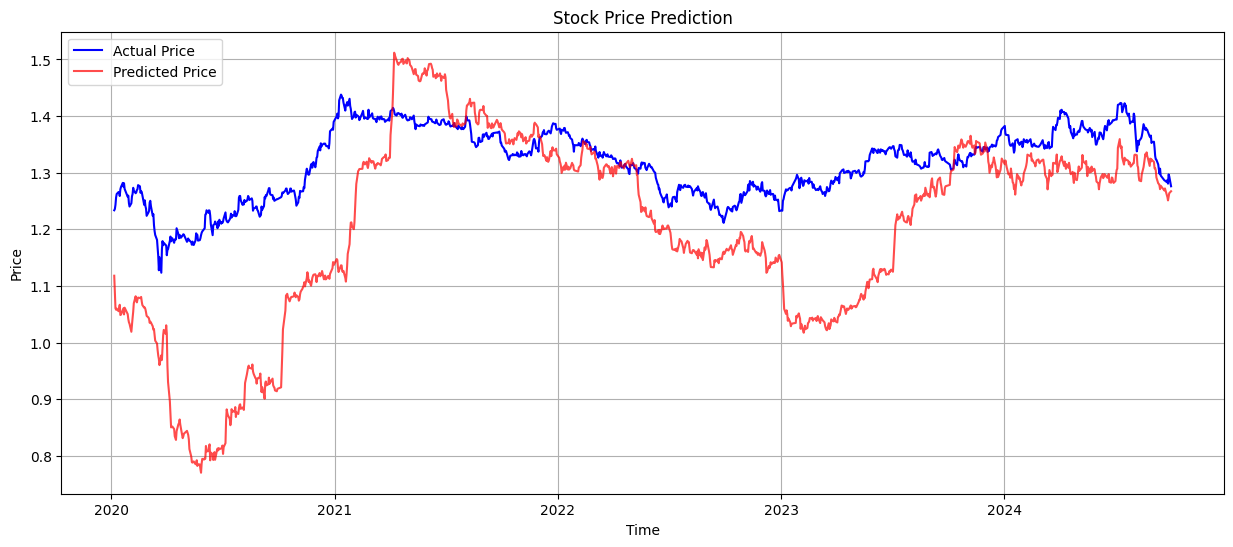

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates) # 극대화되는 듯

# 8
6번에 seq = 90

In [ ]:
seq_length = 90
x_train, y_train = create_sequences(x_train_standard, y_train_standard, seq_length)
x_val, y_val = create_sequences(x_val_standard, y_val_standard, seq_length)
x_test, y_test = create_sequences(x_test_standard, y_test_standard, seq_length)


In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.00005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
) # 넘 오래걸린다....

Epoch 1/100
54/54 - 79s - 1s/step - loss: 1.1178 - mae: 0.8048 - val_loss: 0.4082 - val_mae: 0.5714
Epoch 2/100
54/54 - 79s - 1s/step - loss: 0.4047 - mae: 0.5012 - val_loss: 0.3465 - val_mae: 0.5067
Epoch 3/100
54/54 - 63s - 1s/step - loss: 0.2893 - mae: 0.4252 - val_loss: 0.2943 - val_mae: 0.4481
Epoch 4/100
54/54 - 64s - 1s/step - loss: 0.2235 - mae: 0.3663 - val_loss: 0.3302 - val_mae: 0.4763
Epoch 5/100
54/54 - 82s - 2s/step - loss: 0.1731 - mae: 0.3223 - val_loss: 0.3152 - val_mae: 0.4581
Epoch 6/100
54/54 - 82s - 2s/step - loss: 0.1407 - mae: 0.2927 - val_loss: 0.3040 - val_mae: 0.4459
Epoch 7/100
54/54 - 64s - 1s/step - loss: 0.1220 - mae: 0.2700 - val_loss: 0.2892 - val_mae: 0.4296
Epoch 8/100
54/54 - 82s - 2s/step - loss: 0.1047 - mae: 0.2478 - val_loss: 0.3094 - val_mae: 0.4500
Epoch 9/100
54/54 - 83s - 2s/step - loss: 0.0969 - mae: 0.2420 - val_loss: 0.2931 - val_mae: 0.4379
Epoch 10/100
54/54 - 81s - 2s/step - loss: 0.0910 - mae: 0.2320 - val_loss: 0.2941 - val_mae: 0.4336

KeyboardInterrupt: 

In [ ]:
lossplot(history)

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

#outlier 제거 전 - int

In [ ]:
same3 = pd.read_csv('/content/drive/MyDrive/same_no_outlier_scaling.csv', parse_dates=['Date'])
int3 = pd.read_csv('/content/drive/MyDrive/int_no_outlier_scaling.csv', parse_dates=['Date'])

In [ ]:
x_train_standard, y_train_standard, x_val_standard, y_val_standard, x_test_standard, y_test_standard, y_minmax_scaler, y_standard_scaler = preprocess_standardization(
    int3, features, target
)

seq_length = 5
x_train, y_train = create_sequences(x_train_standard, y_train_standard, seq_length)
x_val, y_val = create_sequences(x_val_standard, y_val_standard, seq_length)
x_test, y_test = create_sequences(x_test_standard, y_test_standard, seq_length)


In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False,
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 17s - 312ms/step - loss: 0.9111 - mae: 0.7335 - val_loss: 0.9958 - val_mae: 0.5223
Epoch 2/100
55/55 - 8s - 146ms/step - loss: 0.4224 - mae: 0.5102 - val_loss: 0.8639 - val_mae: 0.4423
Epoch 3/100
55/55 - 8s - 150ms/step - loss: 0.3198 - mae: 0.4369 - val_loss: 0.8427 - val_mae: 0.4284
Epoch 4/100
55/55 - 10s - 183ms/step - loss: 0.2627 - mae: 0.3932 - val_loss: 0.9093 - val_mae: 0.4981
Epoch 5/100
55/55 - 11s - 204ms/step - loss: 0.1987 - mae: 0.3456 - val_loss: 0.8175 - val_mae: 0.4028
Epoch 6/100
55/55 - 11s - 208ms/step - loss: 0.1854 - mae: 0.3314 - val_loss: 0.8082 - val_mae: 0.3879
Epoch 7/100
55/55 - 8s - 145ms/step - loss: 0.1527 - mae: 0.3024 - val_loss: 0.7788 - val_mae: 0.3745
Epoch 8/100
55/55 - 10s - 184ms/step - loss: 0.1402 - mae: 0.2874 - val_loss: 0.7791 - val_mae: 0.3843
Epoch 9/100
55/55 - 12s - 221ms/step - loss: 0.1297 - mae: 0.2772 - val_loss: 0.7622 - val_mae: 0.3602
Epoch 10/100
55/55 - 9s - 172ms/step - loss: 0.1117 - mae: 0.2597 - val_loss

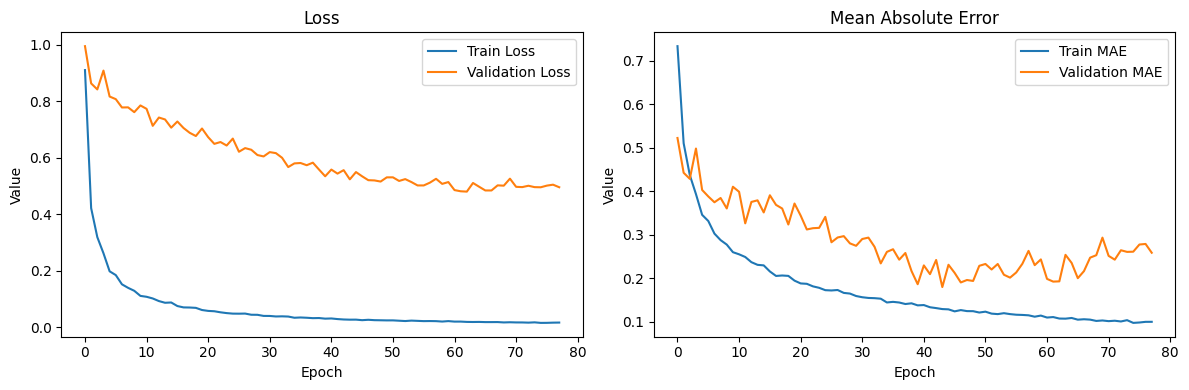

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Absolute Error (MAE): 0.9353631455647109
Root Mean Squared Error (RMSE): 1.1462595015670558


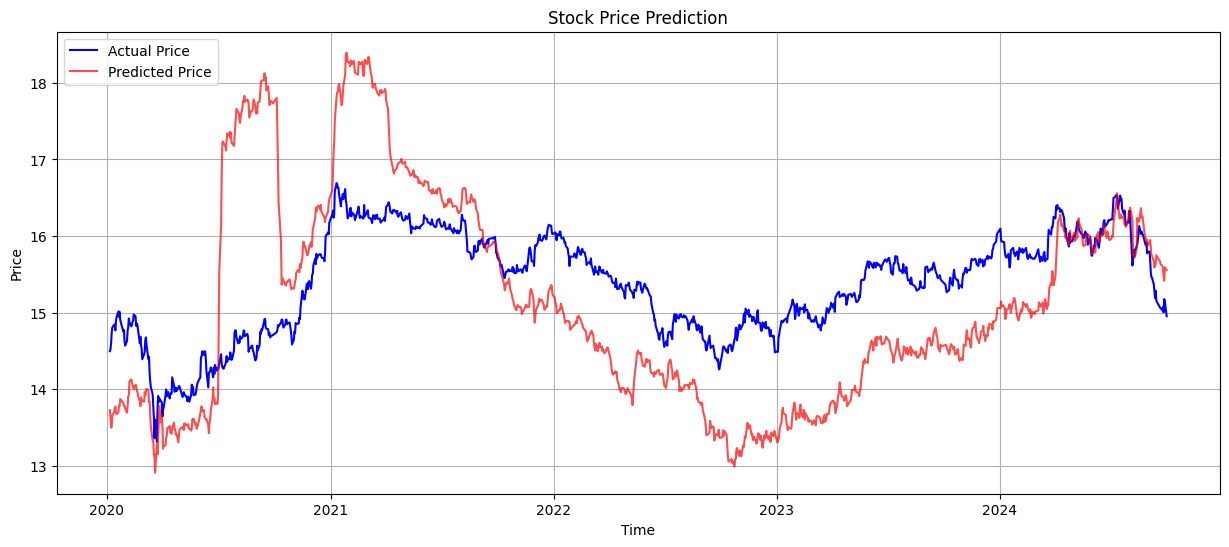

In [ ]:
predictplot(model, x_test, y_test, y_minmax_scaler, dates)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Mean Absolute Error (MAE): 0.08706169983438929
Root Mean Squared Error (RMSE): 0.10669149934272922


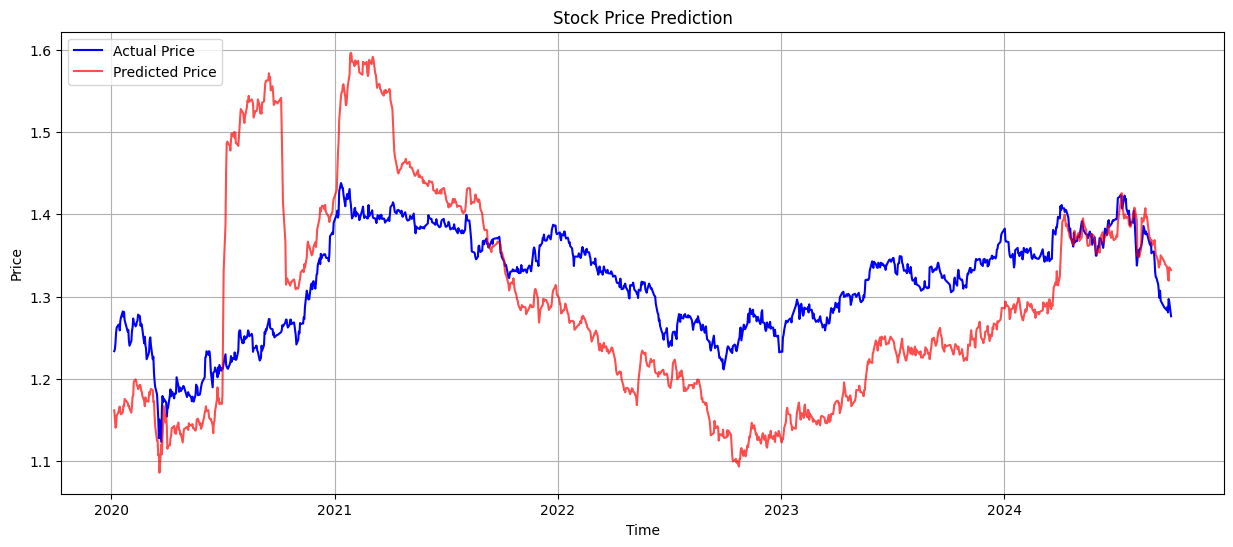

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

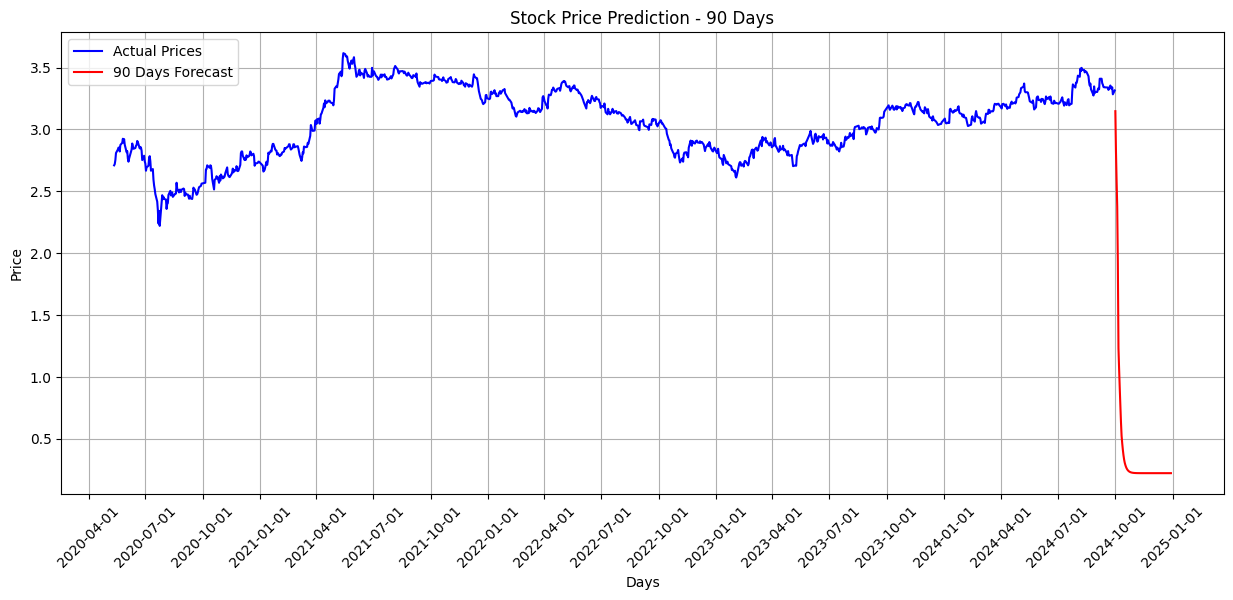

In [ ]:
def predict_future(model, x_test, steps=90):
    """
    미래 예측 수행
    :param model: 학습된 모델
    :param x_test: 테스트 데이터
    :param steps: 예측할 미래의 일수
    :return: 미래 예측값 리스트
    """
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 시퀀스 가져오기

    for i in range(steps):
        # 모델 예측 수행
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # 입력 시퀀스를 업데이트 (shift and append prediction)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1] = prediction

    return np.array(future_predictions)


# y_test를 1D로 변환
y_test = y_test.ravel()

# test_dates 길이를 y_test와 정확히 맞춤
test_dates = int_ddf['Date'][4782:]
test_dates = test_dates[-len(y_test):]  # y_test 길이에 맞춰 슬라이싱

# 미래 날짜 생성
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)

# 미래 예측값 생성
future_90_days = predict_future(model, x_test, steps=90)

# 시각화
plt.figure(figsize=(15, 6))

# 실제 가격 플롯
plt.plot(test_dates, y_test[:len(test_dates)], label='Actual Prices', color='blue')

# 90일 예측 플롯
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')

# 플롯 설정
plt.title('Stock Price Prediction - 90 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')

# 날짜 포맷팅 및 틱 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

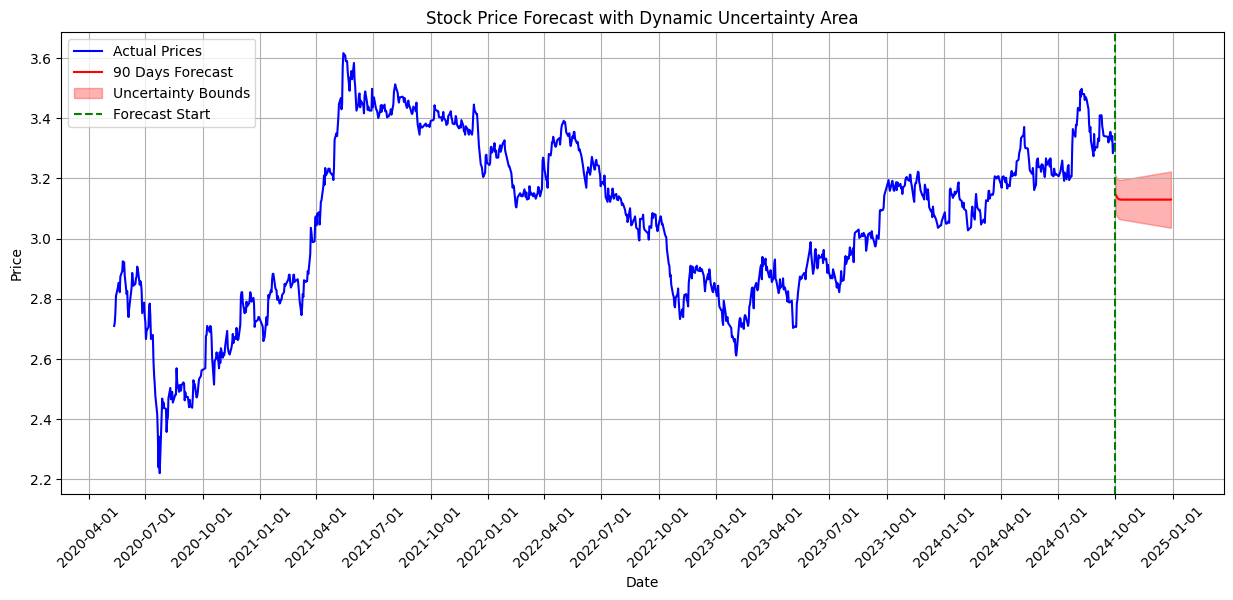

In [ ]:
def predict_future_with_bounds(model, x_test, steps=90):
    """
    미래 예측 수행 및 상한/하한 계산
    :param model: 학습된 모델
    :param x_test: 테스트 데이터
    :param steps: 예측할 미래의 일수
    :return: 미래 예측값, 상한, 하한
    """
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]  # 마지막 시퀀스 가져오기

    for i in range(steps):
        # 모델 예측 수행
        prediction = model.predict(current_input)[0, 0]

        # 불확실성 계산
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 증가

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        # 현재 입력 업데이트 (shift and append prediction)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return (
        np.array(future_predictions),
        np.array(upper_bounds),
        np.array(lower_bounds),
    )


# 테스트 날짜와 y_test 길이 맞춤
test_dates = int_ddf['Date'][4782:]
y_test = y_test.ravel()
test_dates = test_dates[-len(y_test):]

# 미래 날짜 생성
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)

# 90일 미래 예측 수행
future_90_days, upper_90_days, lower_90_days = predict_future_with_bounds(model, x_test, steps=90)

# 시각화
plt.figure(figsize=(15, 6))

# 실제 주식 가격
plt.plot(test_dates, y_test[:len(test_dates)], label="Actual Prices", color="blue")

# 90일 예측 및 불확실성 영역
plt.plot(future_dates, future_90_days, label="90 Days Forecast", color="red")
plt.fill_between(
    future_dates,
    upper_90_days,
    lower_90_days,
    color="red",
    alpha=0.3,
    label="Uncertainty Bounds",
)

# 예측 시작점 표시
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color="green", linestyle="--", label="Forecast Start")

# 플롯 설정
plt.title("Stock Price Forecast with Dynamic Uncertainty Area")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

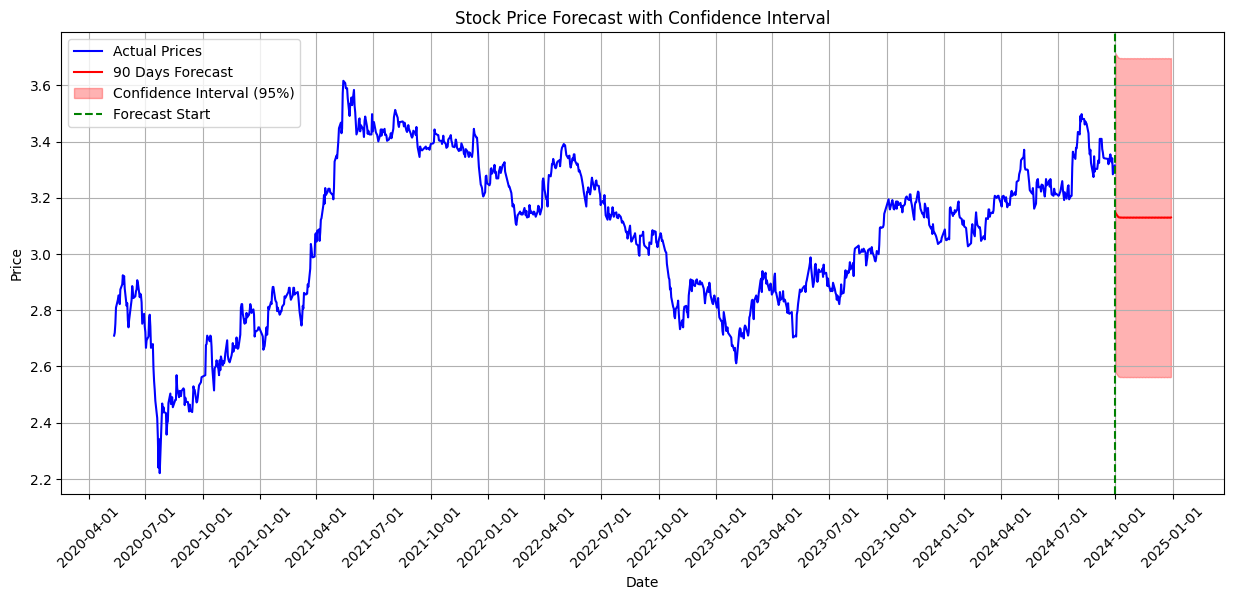

In [ ]:
def predict_future_with_confidence(model, x_test, steps=90):
    """
    미래 예측 수행 및 Confidence Interval 계산
    :param model: 학습된 모델
    :param x_test: 테스트 데이터
    :param steps: 예측할 미래의 일수
    :return: 미래 예측값, 상한선, 하한선
    """
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 시퀀스를 가져옵니다

    # 초기 변동성 계산 (기존 데이터의 표준편차 사용)
    std = np.std(x_test[:, :, -1])

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # 입력 시퀀스 업데이트 (shift and append prediction)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    # Confidence Interval 계산 (95% 신뢰구간)
    future_predictions = np.array(future_predictions)
    upper_bound = future_predictions + 1.96 * std
    lower_bound = future_predictions - 1.96 * std

    return future_predictions, upper_bound, lower_bound


# 테스트 날짜와 y_test 길이 맞춤
test_dates = int_ddf['Date'][4782:]
y_test = y_test.ravel()
test_dates = test_dates[-len(y_test):]

# 미래 날짜 생성
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)

# 미래 예측 수행
future_90_days, upper_90_days, lower_90_days = predict_future_with_confidence(model, x_test, steps=90)

# 시각화
plt.figure(figsize=(15, 6))

# 실제 가격
plt.plot(test_dates, y_test[:len(test_dates)], label="Actual Prices", color="blue")

# 예측값과 Confidence Interval
plt.plot(future_dates, future_90_days, label="90 Days Forecast", color="red")
plt.fill_between(
    future_dates,
    upper_90_days,
    lower_90_days,
    color="red",
    alpha=0.3,
    label="Confidence Interval (95%)",
)

# 예측 시작점 표시
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color="green", linestyle="--", label="Forecast Start")

# 플롯 설정
plt.title("Stock Price Forecast with Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

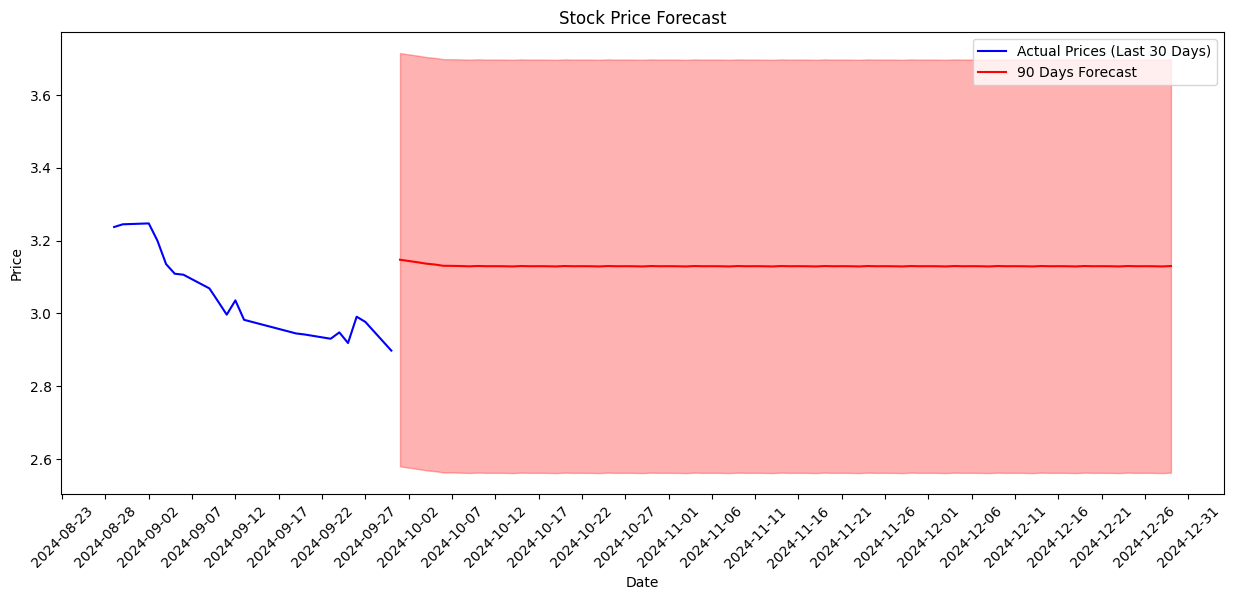

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
#plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

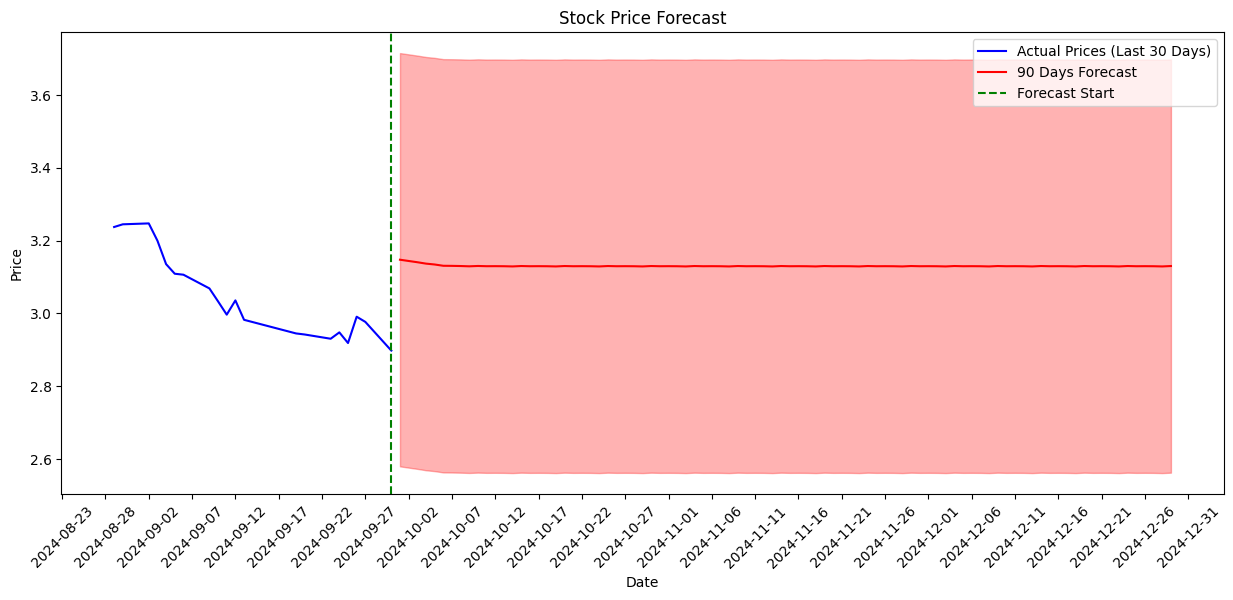

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound

future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

# 2
num_heads=8, key_dim=64, ff_dim=256, num_blocks=3, dropout_rate=0.3,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=64, ff_dim=256, num_blocks=3, dropout_rate=0.3,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 24s - 437ms/step - loss: 0.8428 - mae: 0.6732 - val_loss: 0.7537 - val_mae: 0.6378
Epoch 2/100
55/55 - 7s - 132ms/step - loss: 0.1895 - mae: 0.3416 - val_loss: 0.7387 - val_mae: 0.6183
Epoch 3/100
55/55 - 13s - 239ms/step - loss: 0.1297 - mae: 0.2828 - val_loss: 0.8970 - val_mae: 0.7057
Epoch 4/100
55/55 - 19s - 351ms/step - loss: 0.0964 - mae: 0.2420 - val_loss: 0.9398 - val_mae: 0.7195
Epoch 5/100
55/55 - 15s - 273ms/step - loss: 0.0806 - mae: 0.2223 - val_loss: 0.7493 - val_mae: 0.6270
Epoch 6/100
55/55 - 10s - 181ms/step - loss: 0.0689 - mae: 0.2050 - val_loss: 0.9339 - val_mae: 0.7673
Epoch 7/100
55/55 - 9s - 156ms/step - loss: 0.0564 - mae: 0.1856 - val_loss: 0.5949 - val_mae: 0.5324
Epoch 8/100
55/55 - 8s - 142ms/step - loss: 0.0506 - mae: 0.1744 - val_loss: 0.5657 - val_mae: 0.5208
Epoch 9/100
55/55 - 15s - 274ms/step - loss: 0.0450 - mae: 0.1667 - val_loss: 0.6364 - val_mae: 0.5585
Epoch 10/100
55/55 - 20s - 369ms/step - loss: 0.0431 - mae: 0.1635 - val_los

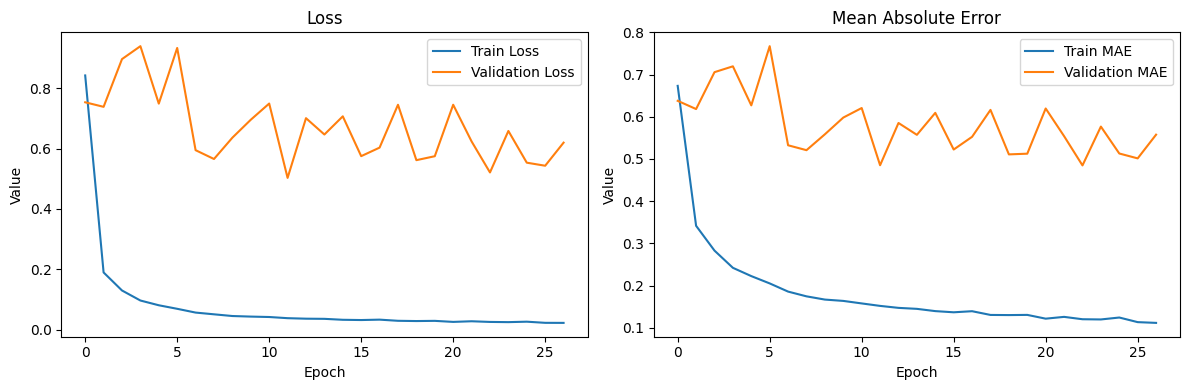

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Absolute Error (MAE): 0.29462675190701487
Root Mean Squared Error (RMSE): 0.30230399873149816


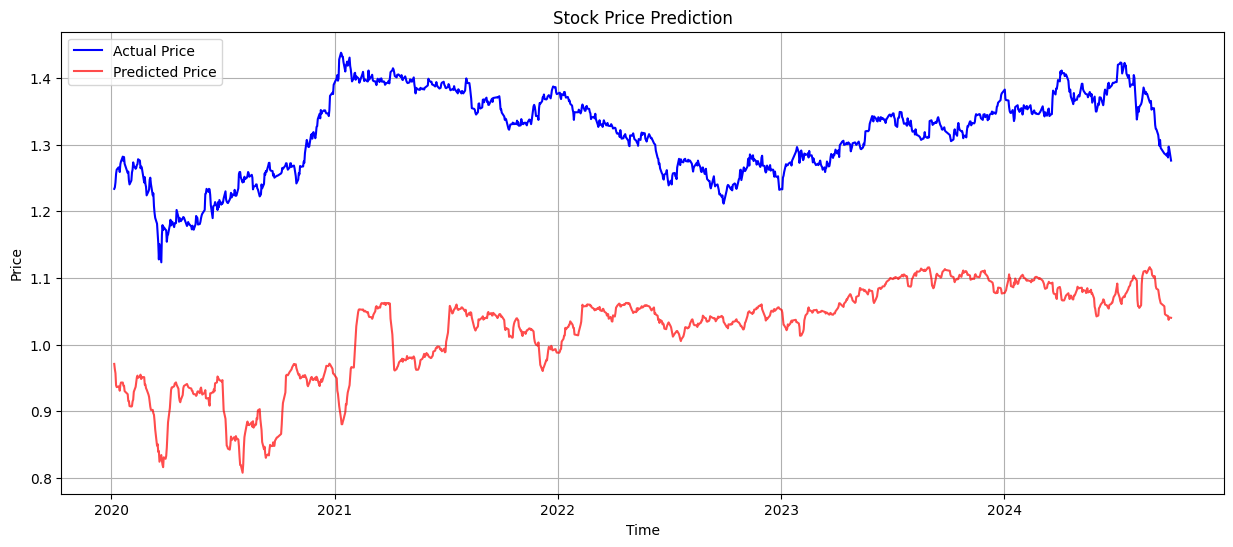

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)



---





---



# feature - same

In [ ]:
same3 = pd.read_csv('/content/drive/MyDrive/same_no_outlier_scaling.csv', parse_dates=['Date'])
int3 = pd.read_csv('/content/drive/MyDrive/int_no_outlier_scaling.csv', parse_dates=['Date'])

x_train_standard, y_train_standard, x_val_standard, y_val_standard, x_test_standard, y_test_standard, y_minmax_scaler, y_standard_scaler = preprocess_standardization(
    same3, features4_same, target)

seq_length = 5
x_train, y_train = create_sequences(x_train_standard, y_train_standard, seq_length)
x_val, y_val = create_sequences(x_val_standard, y_val_standard, seq_length)
x_test, y_test = create_sequences(x_test_standard, y_test_standard, seq_length)

# 1

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False,
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 74s - 1s/step - loss: 0.5714 - mae: 0.5596 - val_loss: 2.0814 - val_mae: 0.6740
Epoch 2/100
55/55 - 9s - 155ms/step - loss: 0.1945 - mae: 0.3300 - val_loss: 1.9817 - val_mae: 0.5945
Epoch 3/100
55/55 - 7s - 131ms/step - loss: 0.1393 - mae: 0.2788 - val_loss: 1.9797 - val_mae: 0.5878
Epoch 4/100
55/55 - 8s - 148ms/step - loss: 0.1147 - mae: 0.2508 - val_loss: 1.9493 - val_mae: 0.5686
Epoch 5/100
55/55 - 7s - 131ms/step - loss: 0.1012 - mae: 0.2334 - val_loss: 1.9493 - val_mae: 0.5653
Epoch 6/100
55/55 - 8s - 148ms/step - loss: 0.0841 - mae: 0.2175 - val_loss: 1.8708 - val_mae: 0.5031
Epoch 7/100
55/55 - 5s - 82ms/step - loss: 0.0793 - mae: 0.2097 - val_loss: 1.8735 - val_mae: 0.5077
Epoch 8/100
55/55 - 5s - 96ms/step - loss: 0.0698 - mae: 0.1968 - val_loss: 1.8982 - val_mae: 0.5252
Epoch 9/100
55/55 - 4s - 70ms/step - loss: 0.0693 - mae: 0.1962 - val_loss: 1.8566 - val_mae: 0.5038
Epoch 10/100
55/55 - 3s - 62ms/step - loss: 0.0636 - mae: 0.1856 - val_loss: 1.8485 - v

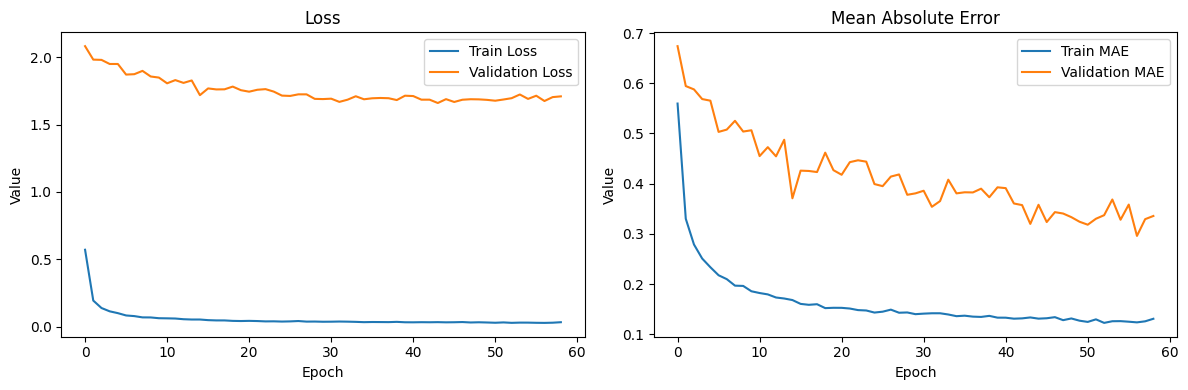

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Mean Absolute Error (MAE): 0.16275742169699972
Root Mean Squared Error (RMSE): 0.17159176642648363


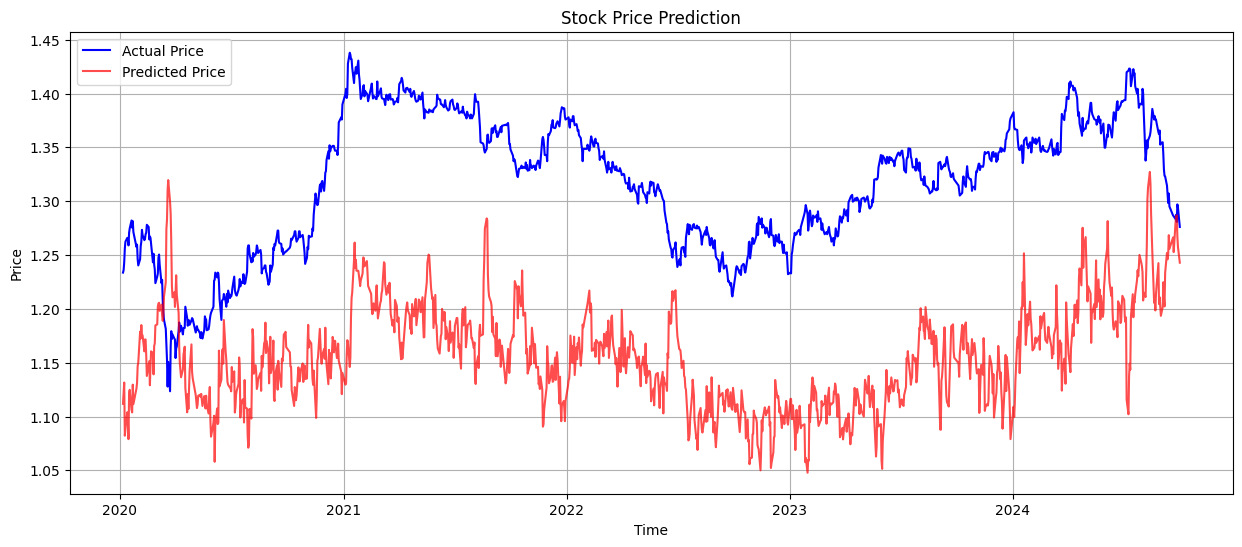

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(y_true, y_pred, threshold=0.1):
    """
    Precision-Recall Curve
    :param y_true: 실제 값
    :param y_pred: 예측 값
    :param threshold: Positive로 간주할 임계값
    """
    # Positive와 Negative 변환
    y_true_binary = (abs(y_true - y_pred) <= threshold).astype(int)
    y_pred_binary = (abs(y_pred - y_true) <= threshold).astype(int)

    # Precision, Recall 계산
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_binary)
    auc_pr = auc(recall, precision)

    # PR Curve 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'AUC-PR = {auc_pr:.2f}')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
y_test_actual = y_scaler.inverse_transform(y_test)  # 스케일 복원
y_pred_actual = y_scaler.inverse_transform(model.predict(x_test))  # 스케일 복원

plot_pr_curve(y_test_actual, y_pred_actual, threshold=0.1)


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_true, y_pred, threshold=0.1):
    """
    ROC Curve
    :param y_true: 실제 값
    :param y_pred: 예측 값
    :param threshold: Positive로 간주할 임계값
    """
    # Positive와 Negative 변환
    y_true_binary = (abs(y_true - y_pred) <= threshold).astype(int)
    y_pred_binary = (abs(y_pred - y_true) <= threshold).astype(int)

    # ROC Curve 계산
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
    auc_roc = roc_auc_score(y_true_binary, y_pred_binary)

    # ROC Curve 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.', label=f'AUC-ROC = {auc_roc:.2f}')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
plot_roc_curve(y_test_actual, y_pred_actual, threshold=0.1)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def plot_rmse(y_true, y_pred):
    """
    RMSE 시각화
    :param y_true: 실제 값
    :param y_pred: 예측 값
    """
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.bar(["RMSE"], [rmse], color="blue")
    plt.title("Root Mean Squared Error")
    plt.ylabel("RMSE Value")
    plt.grid(True)
    plt.show()

    print(f"RMSE: {rmse:.2f}")


In [ ]:
plot_rmse(y_test_actual, y_pred_actual)

# 2

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=64, ff_dim=256, num_blocks=4, dropout_rate=0.2, lr=0.001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 23s - 415ms/step - loss: 0.2929 - mae: 0.3631 - val_loss: 4.6945 - val_mae: 0.4451
Epoch 2/100
55/55 - 9s - 159ms/step - loss: 0.0627 - mae: 0.1895 - val_loss: 4.7544 - val_mae: 0.4487
Epoch 3/100
55/55 - 7s - 127ms/step - loss: 0.0502 - mae: 0.1687 - val_loss: 4.7394 - val_mae: 0.4447
Epoch 4/100
55/55 - 5s - 95ms/step - loss: 0.0452 - mae: 0.1599 - val_loss: 4.7572 - val_mae: 0.4727
Epoch 5/100
55/55 - 13s - 234ms/step - loss: 0.0413 - mae: 0.1521 - val_loss: 4.7221 - val_mae: 0.4364
Epoch 6/100
55/55 - 7s - 126ms/step - loss: 0.0424 - mae: 0.1534 - val_loss: 4.6790 - val_mae: 0.4499
Epoch 7/100
55/55 - 8s - 139ms/step - loss: 0.0433 - mae: 0.1517 - val_loss: 4.6469 - val_mae: 0.4320
Epoch 8/100
55/55 - 8s - 140ms/step - loss: 0.0448 - mae: 0.1562 - val_loss: 4.6099 - val_mae: 0.4193
Epoch 9/100
55/55 - 7s - 119ms/step - loss: 0.0380 - mae: 0.1423 - val_loss: 4.6005 - val_mae: 0.4810
Epoch 10/100
55/55 - 8s - 150ms/step - loss: 0.0413 - mae: 0.1479 - val_loss: 4.4

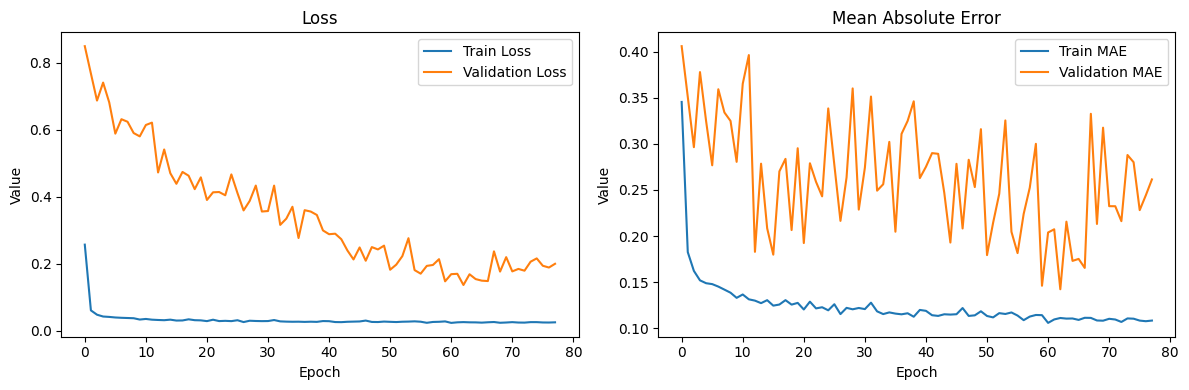

In [ ]:
#lossplot(history)

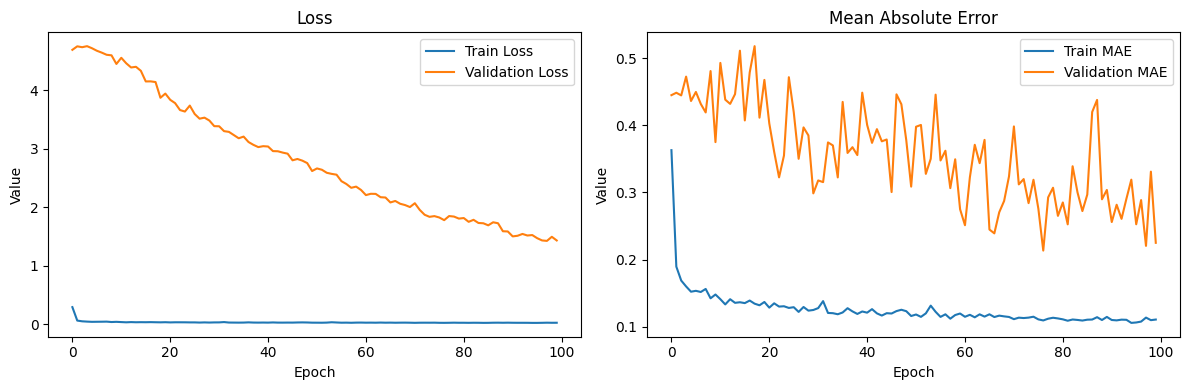

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
Mean Absolute Error (MAE): 0.11256248806799538
Root Mean Squared Error (RMSE): 0.11702829612063155


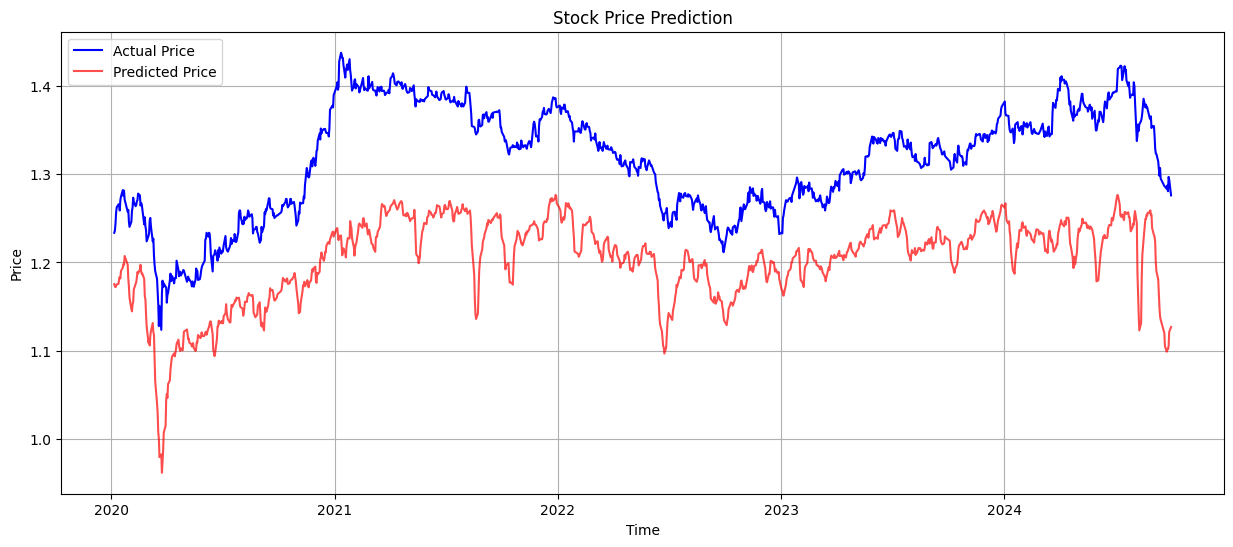

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step
Mean Absolute Error (MAE): 0.13866721166889573
Root Mean Squared Error (RMSE): 0.1417906105550599


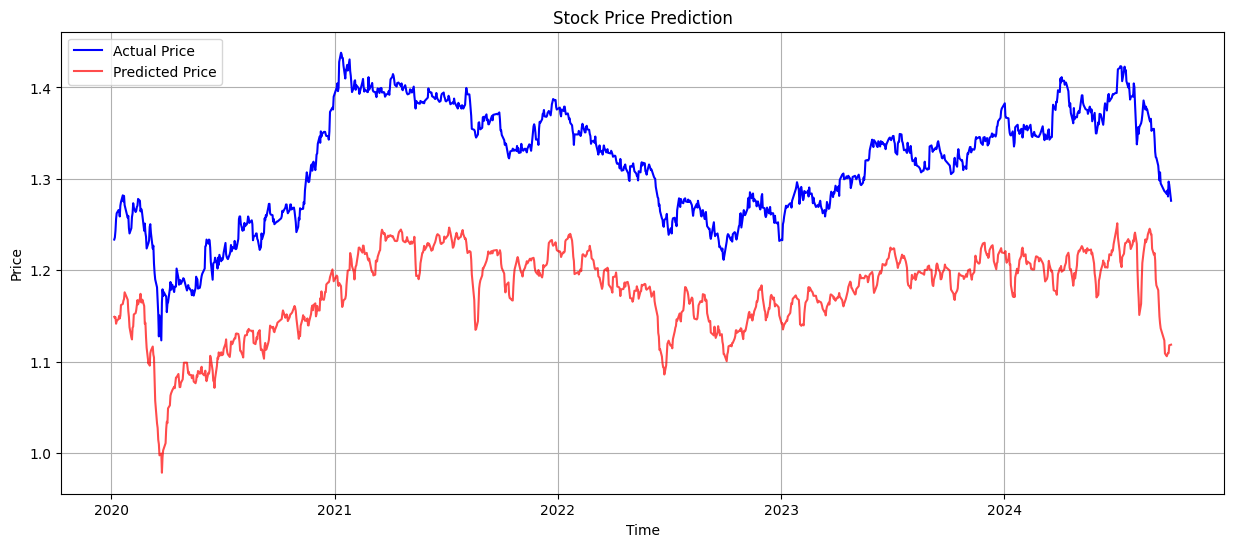

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 

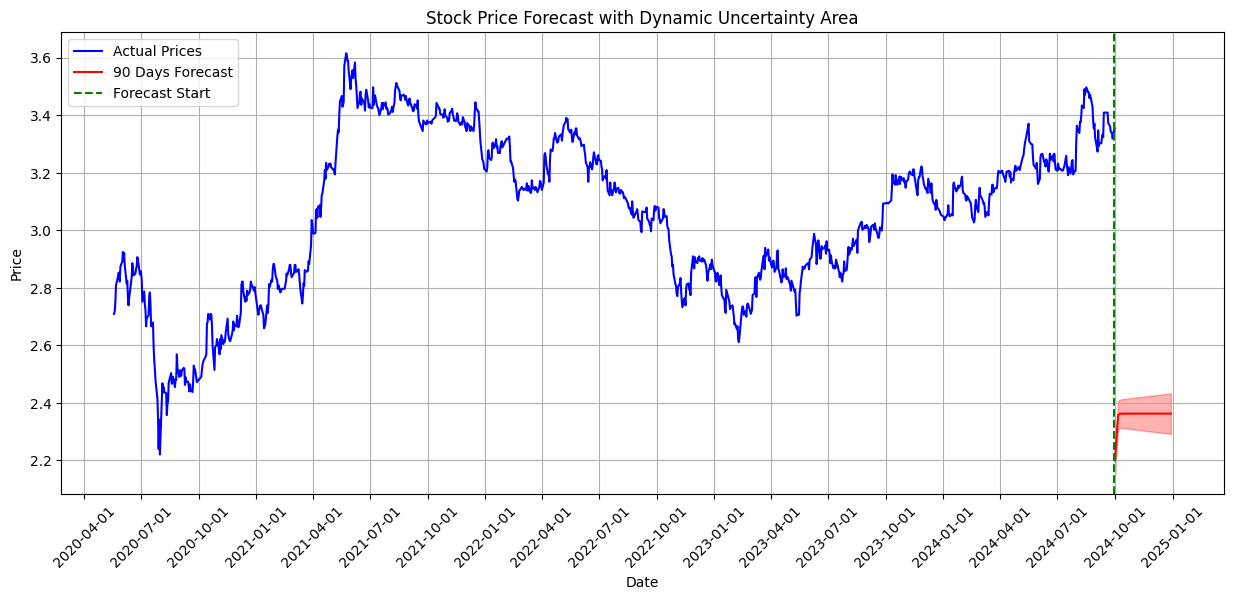

In [ ]:
def predict_future_dynamic(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]

        # 동적으로 불확실성 계산 (처음에는 좁고 끝으로 갈수록 퍼지는 영역)
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 비율 증가 (처음에는 2%, 끝에는 약 12%까지)

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        if feature_generator:
            next_features = feature_generator(current_input, prediction)
        else:
            next_features = current_input[0, 1:, :-1]

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :-1] = next_features
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), np.array(upper_bounds), np.array(lower_bounds)

def simple_feature_generator(current_input, prediction):
    """
    피처 값을 단순히 이전 값으로 유지하는 예제 함수
    """
    last_features = current_input[0, -1, :-1]  # 마지막 피처 값 가져오기
    return last_features

feature_generator = simple_feature_generator
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model, x_test, steps=90, feature_generator=feature_generator)
#test_dates = test_dates[seq_length:]
y_test = y_test.flatten()

# test_dates와 y_test 길이 맞추기
min_length = min(len(test_dates), len(y_test))
test_dates = test_dates[:min_length]
y_test = y_test[:min_length]

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
path= r'/content/drive/MyDrive/Colab Notebooks/Transformer_model_path'
model.save_weights(path+ 'standard_same_feature1.weights.h5')

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(y_true, y_pred, threshold=0.1):
    """
    Precision-Recall Curve
    :param y_true: 실제 값
    :param y_pred: 예측 값
    :param threshold: Positive로 간주할 임계값
    """
    # Positive와 Negative 변환
    y_true_binary = (abs(y_true - y_pred) <= threshold).astype(int)
    y_pred_binary = (abs(y_pred - y_true) <= threshold).astype(int)

    # Precision, Recall 계산
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_binary)
    auc_pr = auc(recall, precision)

    # PR Curve 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'AUC-PR = {auc_pr:.2f}')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


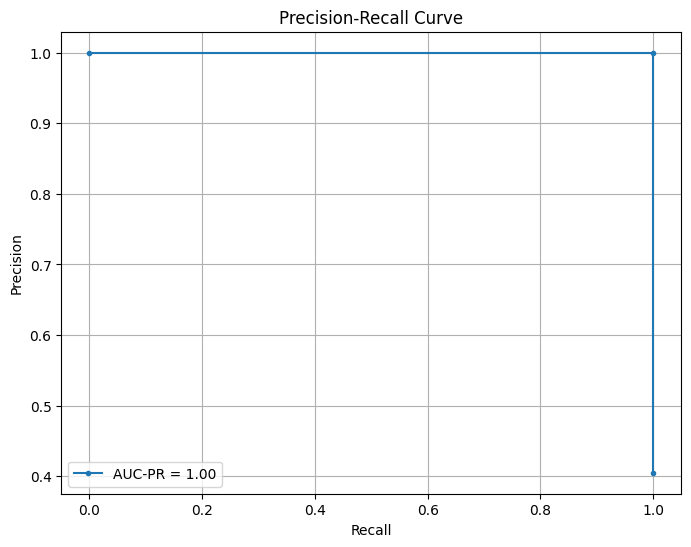

In [ ]:
y_test_actual = y_standard_scaler.inverse_transform(y_test)  # 스케일 복원
y_pred_actual = y_standard_scaler.inverse_transform(model.predict(x_test))  # 스케일 복원

plot_pr_curve(y_test_actual, y_pred_actual, threshold=0.1)


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_true, y_pred, threshold=0.1):
    """
    ROC Curve
    :param y_true: 실제 값
    :param y_pred: 예측 값
    :param threshold: Positive로 간주할 임계값
    """
    # Positive와 Negative 변환
    y_true_binary = (abs(y_true - y_pred) <= threshold).astype(int)
    y_pred_binary = (abs(y_pred - y_true) <= threshold).astype(int)

    # ROC Curve 계산
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
    auc_roc = roc_auc_score(y_true_binary, y_pred_binary)

    # ROC Curve 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.', label=f'AUC-ROC = {auc_roc:.2f}')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

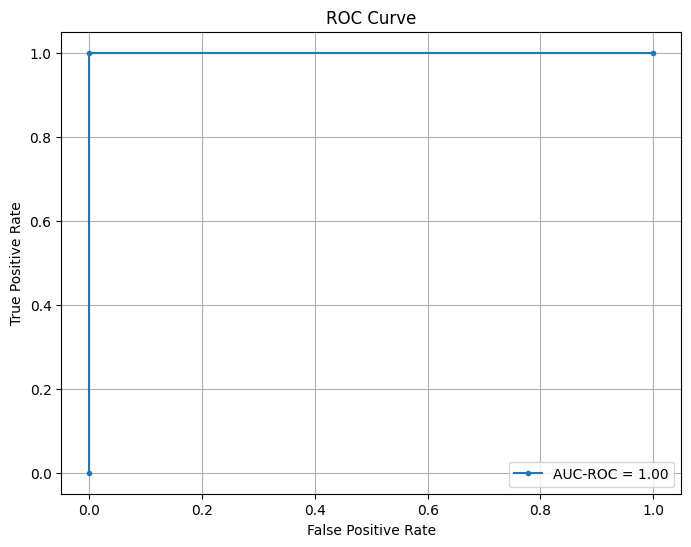

In [ ]:
plot_roc_curve(y_test_actual, y_pred_actual, threshold=0.1)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def plot_rmse(y_true, y_pred):
    """
    RMSE 시각화
    :param y_true: 실제 값
    :param y_pred: 예측 값
    """
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.bar(["RMSE"], [rmse], color="blue")
    plt.title("Root Mean Squared Error")
    plt.ylabel("RMSE Value")
    plt.grid(True)
    plt.show()

    print(f"RMSE: {rmse:.2f}")

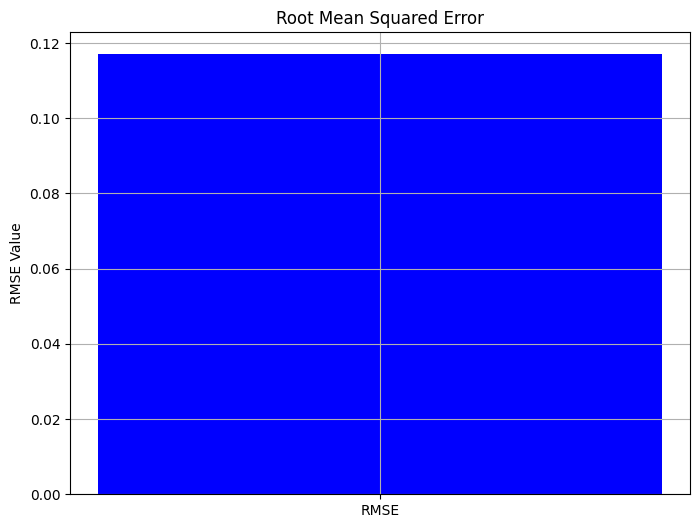

RMSE: 0.12


In [ ]:
plot_rmse(y_test_actual, y_pred_actual)

# 3 xx

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.1, lr=0.0005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 16s - 284ms/step - loss: 0.7451 - mae: 0.5711 - val_loss: 8.4765 - val_mae: 1.8516
Epoch 2/100
55/55 - 3s - 61ms/step - loss: 0.1411 - mae: 0.2654 - val_loss: 7.4079 - val_mae: 1.7342
Epoch 3/100
55/55 - 3s - 60ms/step - loss: 0.0928 - mae: 0.2201 - val_loss: 6.4123 - val_mae: 1.5544
Epoch 4/100
55/55 - 7s - 121ms/step - loss: 0.0719 - mae: 0.1939 - val_loss: 5.9516 - val_mae: 1.4671
Epoch 5/100
55/55 - 4s - 78ms/step - loss: 0.0607 - mae: 0.1789 - val_loss: 5.6903 - val_mae: 1.3984
Epoch 6/100
55/55 - 4s - 80ms/step - loss: 0.0521 - mae: 0.1671 - val_loss: 5.5173 - val_mae: 1.4106
Epoch 7/100
55/55 - 7s - 120ms/step - loss: 0.0463 - mae: 0.1571 - val_loss: 5.3914 - val_mae: 1.3396
Epoch 8/100
55/55 - 4s - 81ms/step - loss: 0.0414 - mae: 0.1508 - val_loss: 5.2772 - val_mae: 1.3238
Epoch 9/100
55/55 - 4s - 76ms/step - loss: 0.0409 - mae: 0.1522 - val_loss: 4.9139 - val_mae: 1.2590
Epoch 10/100
55/55 - 7s - 121ms/step - loss: 0.0379 - mae: 0.1424 - val_loss: 4.9242 - 

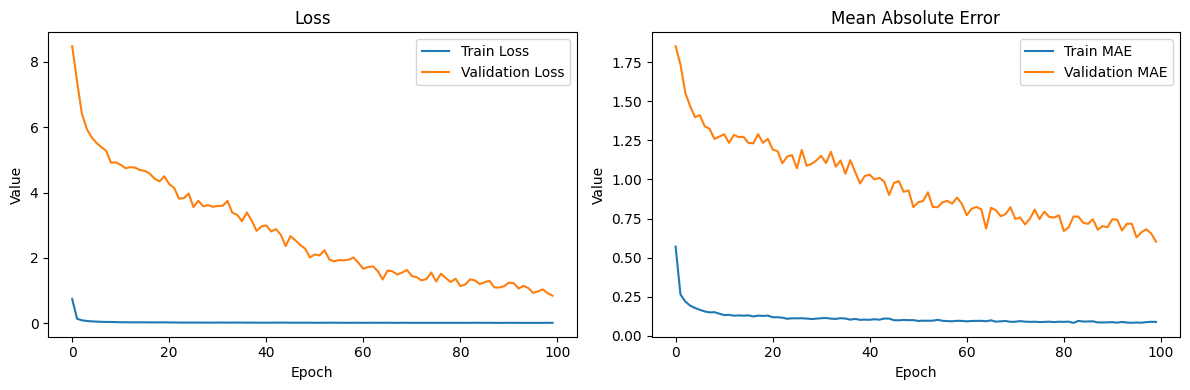

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Mean Absolute Error (MAE): 0.4659603186232874
Root Mean Squared Error (RMSE): 0.47384306916846325


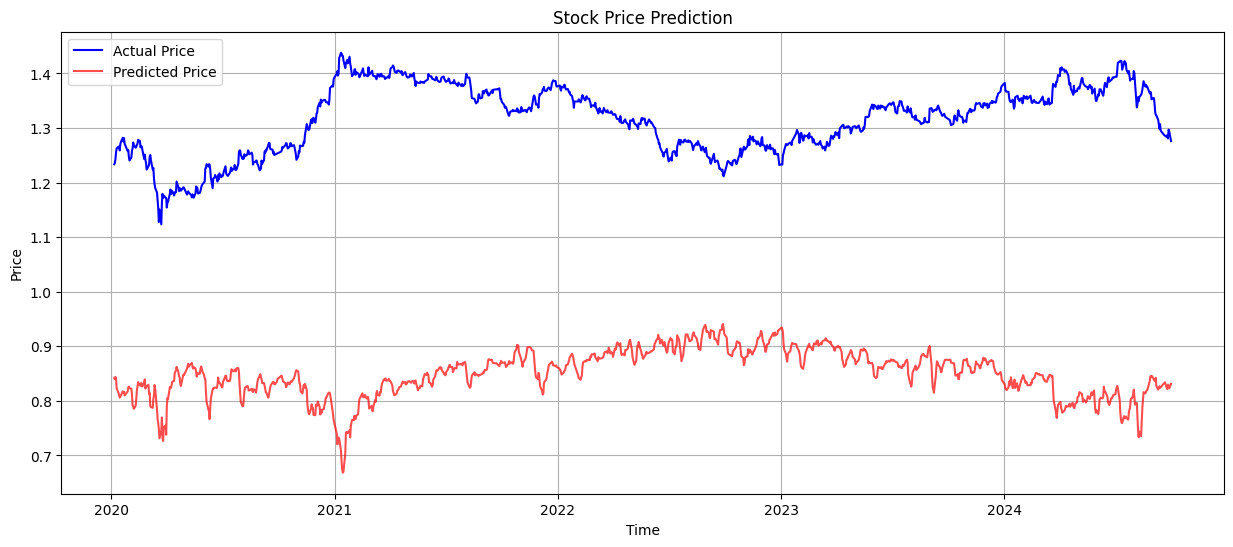

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

# 4



In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 17s - 313ms/step - loss: 0.6490 - mae: 0.5746 - val_loss: 4.3603 - val_mae: 0.9543
Epoch 2/100
55/55 - 4s - 77ms/step - loss: 0.1726 - mae: 0.3141 - val_loss: 4.1383 - val_mae: 0.8398
Epoch 3/100
55/55 - 8s - 139ms/step - loss: 0.1312 - mae: 0.2755 - val_loss: 4.1018 - val_mae: 0.8429
Epoch 4/100
55/55 - 8s - 139ms/step - loss: 0.1031 - mae: 0.2406 - val_loss: 4.0540 - val_mae: 0.8134
Epoch 5/100
55/55 - 4s - 78ms/step - loss: 0.0960 - mae: 0.2287 - val_loss: 3.8967 - val_mae: 0.7386
Epoch 6/100
55/55 - 5s - 93ms/step - loss: 0.0776 - mae: 0.2075 - val_loss: 3.8769 - val_mae: 0.7404
Epoch 7/100
55/55 - 3s - 63ms/step - loss: 0.0742 - mae: 0.2022 - val_loss: 3.8031 - val_mae: 0.7103
Epoch 8/100
55/55 - 5s - 93ms/step - loss: 0.0657 - mae: 0.1907 - val_loss: 3.8824 - val_mae: 0.7475
Epoch 9/100
55/55 - 6s - 117ms/step - loss: 0.0629 - mae: 0.1860 - val_loss: 3.8332 - val_mae: 0.7458
Epoch 10/100
55/55 - 4s - 69ms/step - loss: 0.0557 - mae: 0.1770 - val_loss: 3.7945 - 

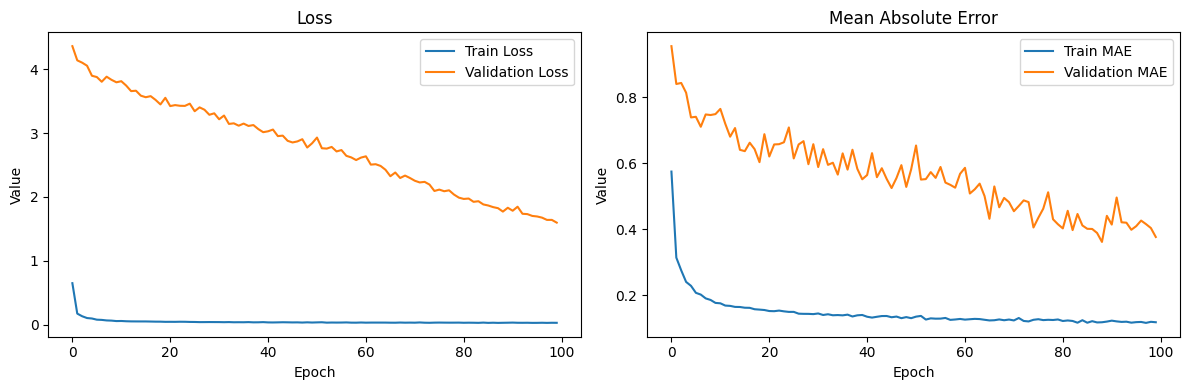

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Mean Absolute Error (MAE): 0.23559140691359992
Root Mean Squared Error (RMSE): 0.24035436645353322


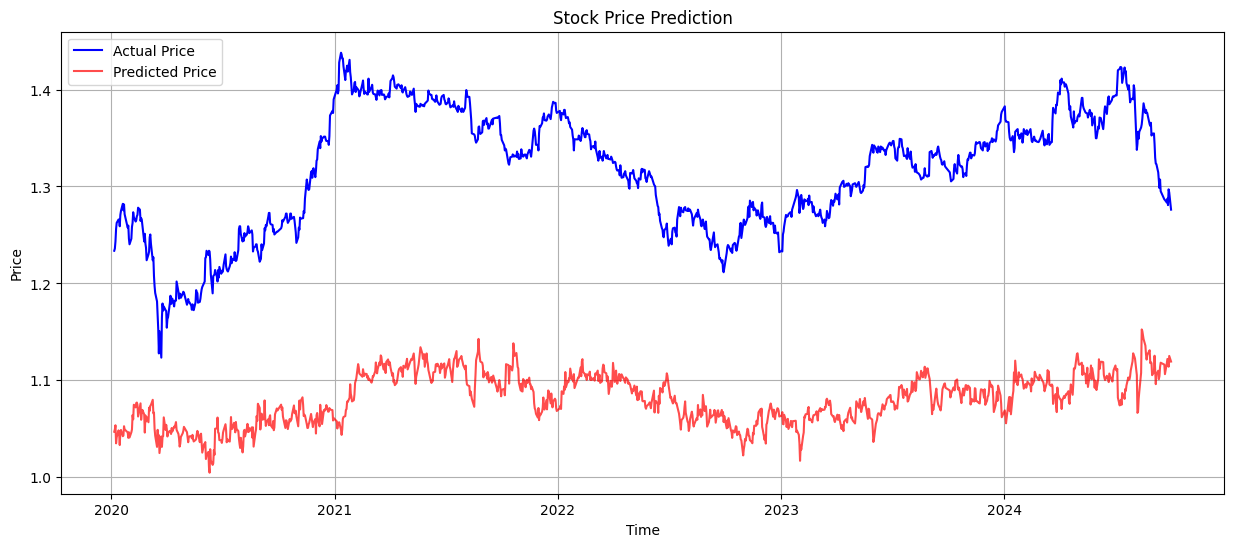

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates) # 둔감

# 5

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.00005,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 15s - 269ms/step - loss: 1.3287 - mae: 0.8302 - val_loss: 6.8468 - val_mae: 2.0105
Epoch 2/100
55/55 - 5s - 89ms/step - loss: 0.4167 - mae: 0.4677 - val_loss: 5.0881 - val_mae: 1.6542
Epoch 3/100
55/55 - 6s - 106ms/step - loss: 0.2609 - mae: 0.3673 - val_loss: 4.4353 - val_mae: 1.4768
Epoch 4/100
55/55 - 4s - 73ms/step - loss: 0.1757 - mae: 0.3105 - val_loss: 4.3902 - val_mae: 1.4594
Epoch 5/100
55/55 - 6s - 111ms/step - loss: 0.1505 - mae: 0.2854 - val_loss: 4.1736 - val_mae: 1.4035
Epoch 6/100
55/55 - 5s - 88ms/step - loss: 0.1307 - mae: 0.2627 - val_loss: 3.9955 - val_mae: 1.3677
Epoch 7/100
55/55 - 4s - 80ms/step - loss: 0.1185 - mae: 0.2531 - val_loss: 3.8351 - val_mae: 1.3154
Epoch 8/100
55/55 - 7s - 123ms/step - loss: 0.1097 - mae: 0.2497 - val_loss: 3.7897 - val_mae: 1.3164
Epoch 9/100
55/55 - 4s - 77ms/step - loss: 0.1035 - mae: 0.2369 - val_loss: 3.6052 - val_mae: 1.2636
Epoch 10/100
55/55 - 4s - 76ms/step - loss: 0.0883 - mae: 0.2178 - val_loss: 3.4707 - 

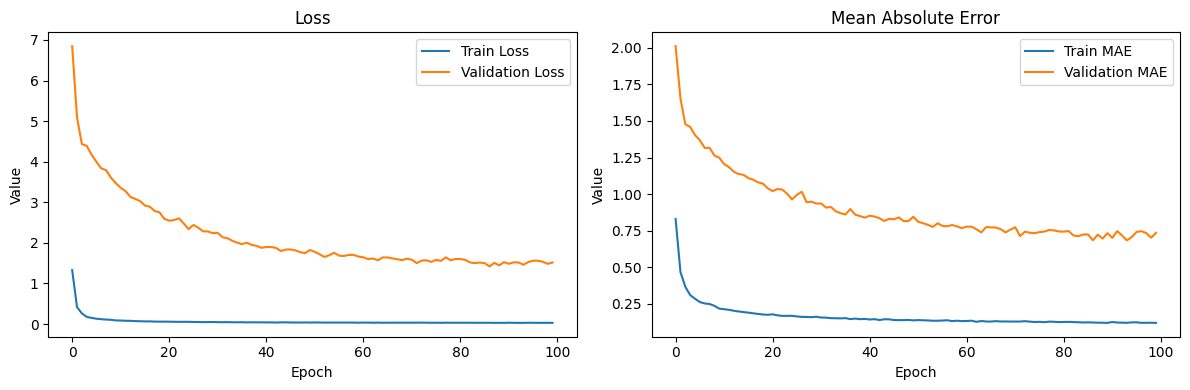

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Mean Absolute Error (MAE): 0.5817278084358412
Root Mean Squared Error (RMSE): 0.5875592558291111


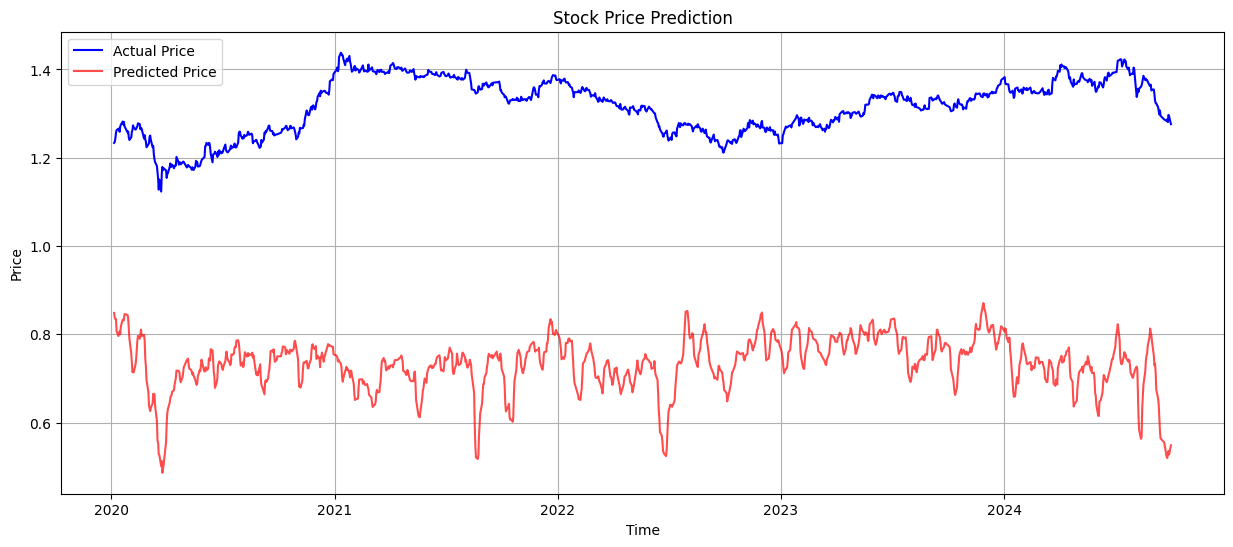

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

# feature - int

In [ ]:
same3 = pd.read_csv('/content/drive/MyDrive/same_no_outlier_scaling.csv', parse_dates=['Date'])
int3 = pd.read_csv('/content/drive/MyDrive/int_no_outlier_scaling.csv', parse_dates=['Date'])

x_train_standard, y_train_standard, x_val_standard, y_val_standard, x_test_standard, y_test_standard, y_minmax_scaler, y_standard_scaler = preprocess_standardization(
    int3, features4_int, target)

seq_length = 5
x_train, y_train = create_sequences(x_train_standard, y_train_standard, seq_length)
x_val, y_val = create_sequences(x_val_standard, y_val_standard, seq_length)
x_test, y_test = create_sequences(x_test_standard, y_test_standard, seq_length)

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=4, key_dim=128, ff_dim=256, num_blocks=3, dropout_rate=0.2, lr=0.0001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False,
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 16s - 285ms/step - loss: 2.2541 - mae: 1.0189 - val_loss: 23.1936 - val_mae: 3.9009
Epoch 2/100
55/55 - 7s - 127ms/step - loss: 0.4252 - mae: 0.4848 - val_loss: 18.9484 - val_mae: 3.2569
Epoch 3/100
55/55 - 8s - 141ms/step - loss: 0.2543 - mae: 0.3863 - val_loss: 17.3599 - val_mae: 3.0427
Epoch 4/100
55/55 - 8s - 138ms/step - loss: 0.2169 - mae: 0.3509 - val_loss: 16.0086 - val_mae: 2.7975
Epoch 5/100
55/55 - 8s - 140ms/step - loss: 0.1720 - mae: 0.3158 - val_loss: 15.2985 - val_mae: 2.7030
Epoch 6/100
55/55 - 8s - 139ms/step - loss: 0.1458 - mae: 0.2886 - val_loss: 14.3908 - val_mae: 2.5561
Epoch 7/100
55/55 - 8s - 139ms/step - loss: 0.1208 - mae: 0.2649 - val_loss: 13.4669 - val_mae: 2.4121
Epoch 8/100
55/55 - 7s - 134ms/step - loss: 0.1172 - mae: 0.2597 - val_loss: 12.9264 - val_mae: 2.3095
Epoch 9/100
55/55 - 8s - 143ms/step - loss: 0.1006 - mae: 0.2428 - val_loss: 12.7448 - val_mae: 2.2736
Epoch 10/100
55/55 - 7s - 135ms/step - loss: 0.0963 - mae: 0.2366 - val_

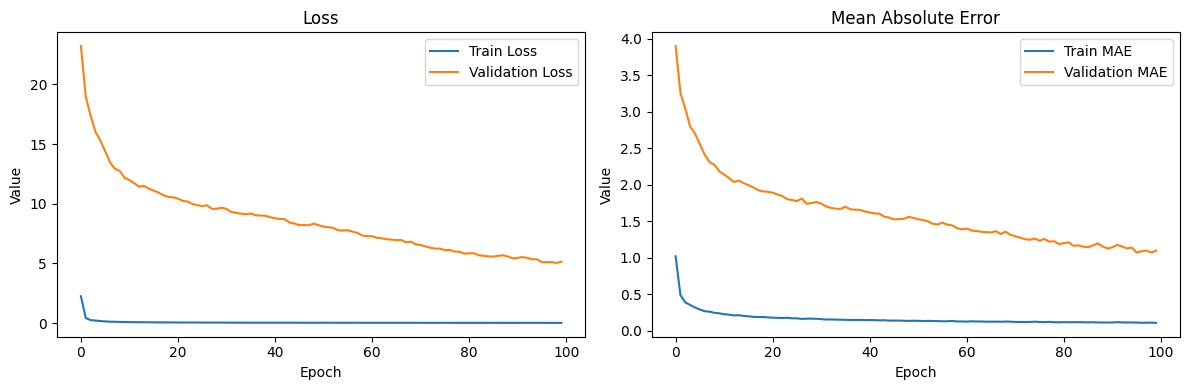

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Mean Absolute Error (MAE): 0.8536799354275083
Root Mean Squared Error (RMSE): 0.8630286747992644


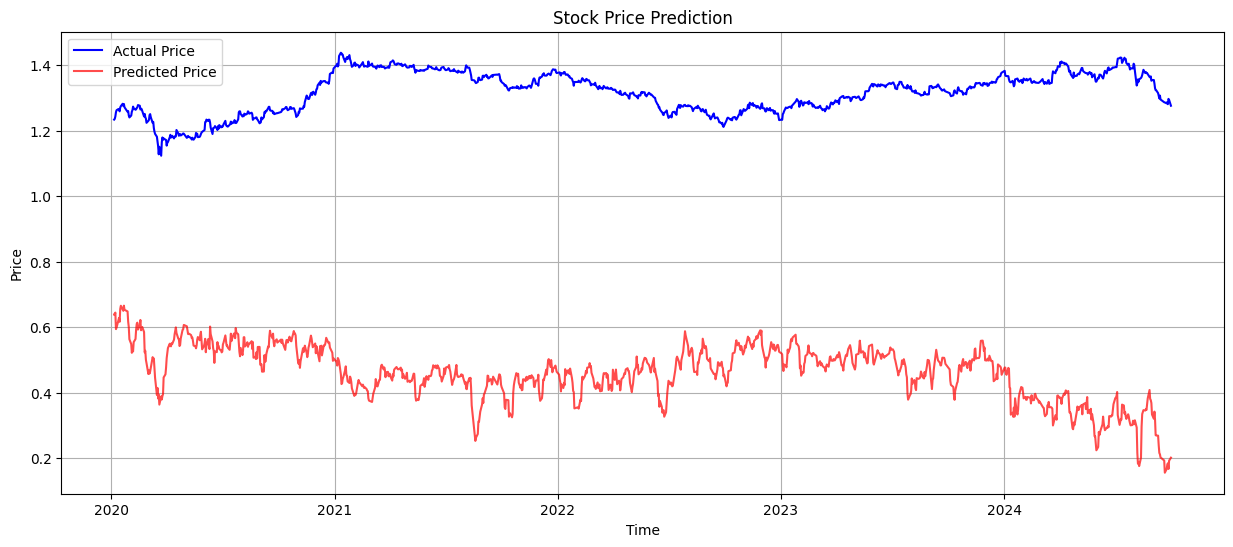

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

# 이거다 이거!!

In [ ]:
history, model = train_model(
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    num_heads=8, key_dim=64, ff_dim=256, num_blocks=4, dropout_rate=0.2, lr=0.001,
    initial_learning_rate=0.0005, decay_steps=5000, decay_rate=0.95, staircase=False, ##
    epochs=100, batch_size=64
)

Epoch 1/100
55/55 - 22s - 394ms/step - loss: 0.2561 - mae: 0.3357 - val_loss: 2.5959 - val_mae: 0.9999
Epoch 2/100
55/55 - 5s - 83ms/step - loss: 0.0615 - mae: 0.1869 - val_loss: 2.1286 - val_mae: 0.8920
Epoch 3/100
55/55 - 6s - 112ms/step - loss: 0.0552 - mae: 0.1758 - val_loss: 1.8621 - val_mae: 0.9565
Epoch 4/100
55/55 - 9s - 169ms/step - loss: 0.0474 - mae: 0.1614 - val_loss: 1.7441 - val_mae: 0.8469
Epoch 5/100
55/55 - 11s - 205ms/step - loss: 0.0457 - mae: 0.1562 - val_loss: 1.6342 - val_mae: 0.8326
Epoch 6/100
55/55 - 18s - 327ms/step - loss: 0.0375 - mae: 0.1433 - val_loss: 1.3207 - val_mae: 0.7528
Epoch 7/100
55/55 - 11s - 196ms/step - loss: 0.0354 - mae: 0.1366 - val_loss: 1.5001 - val_mae: 0.7797
Epoch 8/100
55/55 - 5s - 82ms/step - loss: 0.0423 - mae: 0.1491 - val_loss: 1.2841 - val_mae: 0.6838
Epoch 9/100
55/55 - 5s - 87ms/step - loss: 0.0429 - mae: 0.1522 - val_loss: 1.3036 - val_mae: 0.7048
Epoch 10/100
55/55 - 7s - 127ms/step - loss: 0.0350 - mae: 0.1381 - val_loss: 1.1

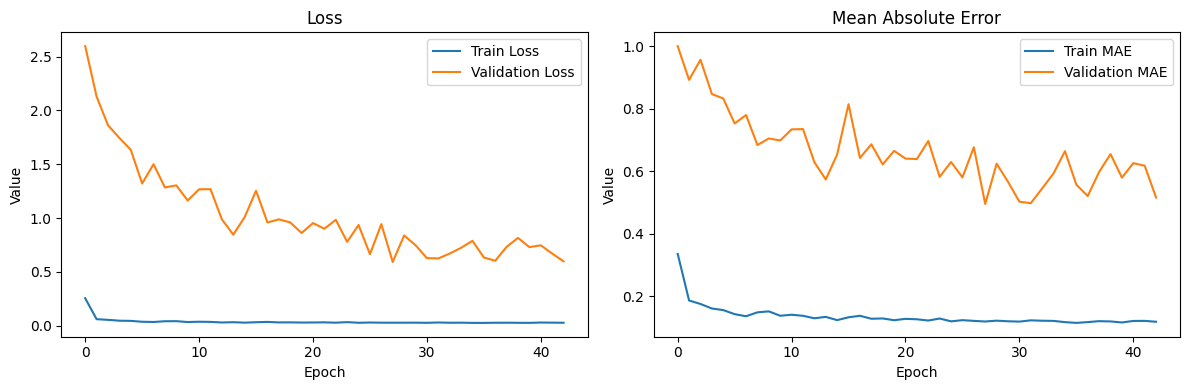

In [ ]:
lossplot(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Mean Absolute Error (MAE): 0.03423202440151558
Root Mean Squared Error (RMSE): 0.03742131623287453


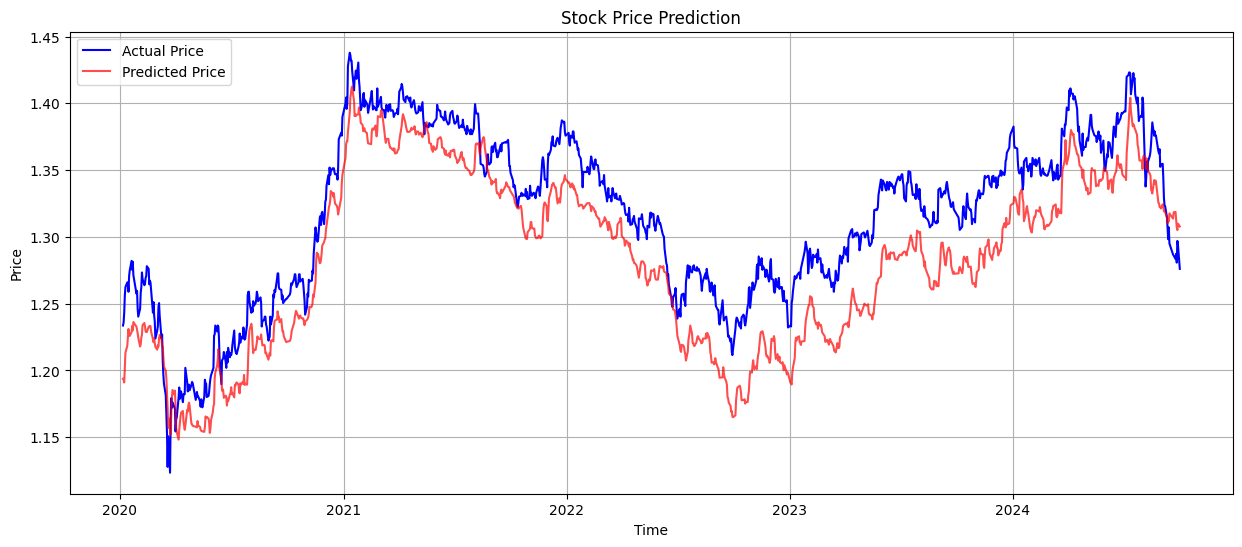

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

In [ ]:
predictplot(model, x_test, y_test, y_standard_scaler, dates)

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step


ValueError: Expected 2D array, got 1D array instead:
array=[2.709777   2.71965843 2.75221702 ... 3.33828834 3.31943984 3.35462327].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

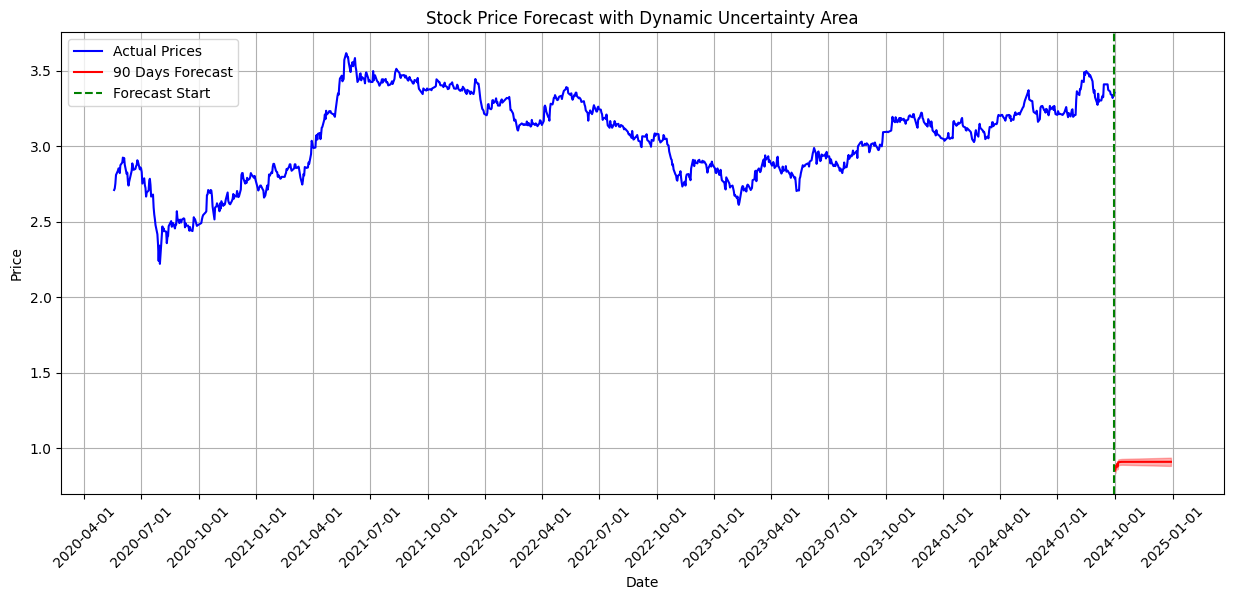

In [ ]:
def predict_future_dynamic(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]

        # 동적으로 불확실성 계산 (처음에는 좁고 끝으로 갈수록 퍼지는 영역)
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 비율 증가 (처음에는 2%, 끝에는 약 12%까지)

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        if feature_generator:
            next_features = feature_generator(current_input, prediction)
        else:
            next_features = current_input[0, 1:, :-1]

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :-1] = next_features
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), np.array(upper_bounds), np.array(lower_bounds)

def simple_feature_generator(current_input, prediction):
    """
    피처 값을 단순히 이전 값으로 유지하는 예제 함수
    """
    last_features = current_input[0, -1, :-1]  # 마지막 피처 값 가져오기
    return last_features

feature_generator = simple_feature_generator
future_90_days, upper_90_days, lower_90_days = predict_future_dynamic(model, x_test, steps=90, feature_generator=feature_generator)
#test_dates = test_dates[seq_length:]
y_test = y_test.flatten()

# test_dates와 y_test 길이 맞추기
min_length = min(len(test_dates), len(y_test))
test_dates = test_dates[:min_length]
y_test = y_test[:min_length]

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

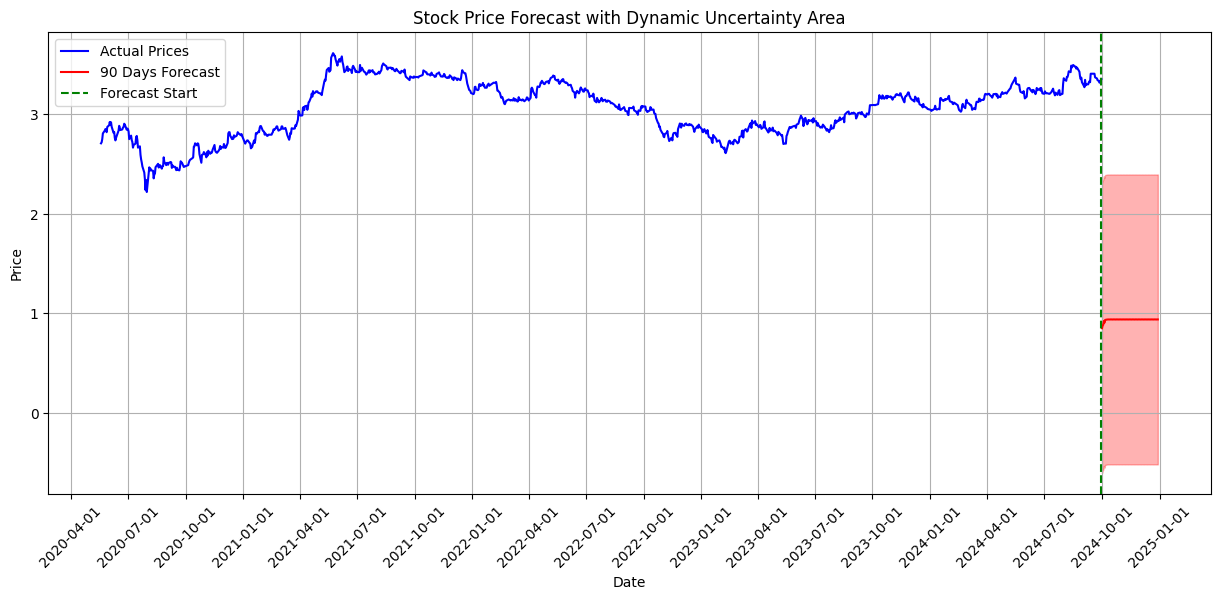

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound



future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast with Dynamic Uncertainty Area')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
path= r'/content/drive/MyDrive/Colab Notebooks/Transformer_model_path'
model.save_weights(path+ 'standard_int_feature1.weights.h5')

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


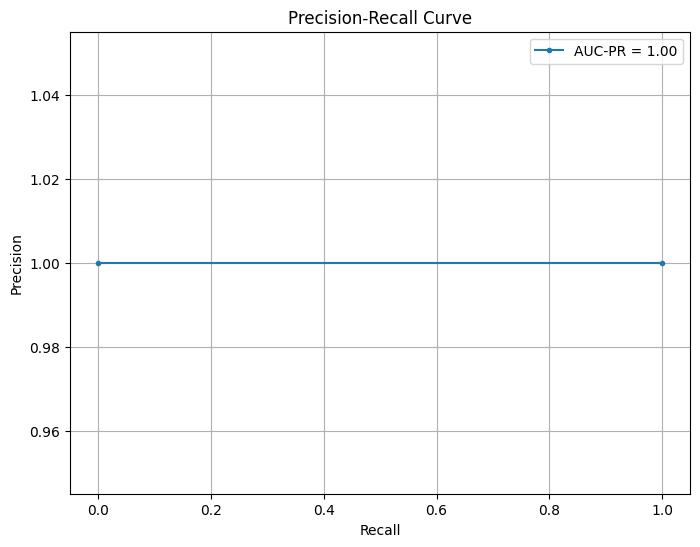

In [ ]:
y_test_actual = y_standard_scaler.inverse_transform(y_test)  # 스케일 복원
y_pred_actual = y_standard_scaler.inverse_transform(model.predict(x_test))  # 스케일 복원

plot_pr_curve(y_test_actual, y_pred_actual, threshold=0.1)

In [ ]:
plot_roc_curve(y_test_actual, y_pred_actual, threshold=0.1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

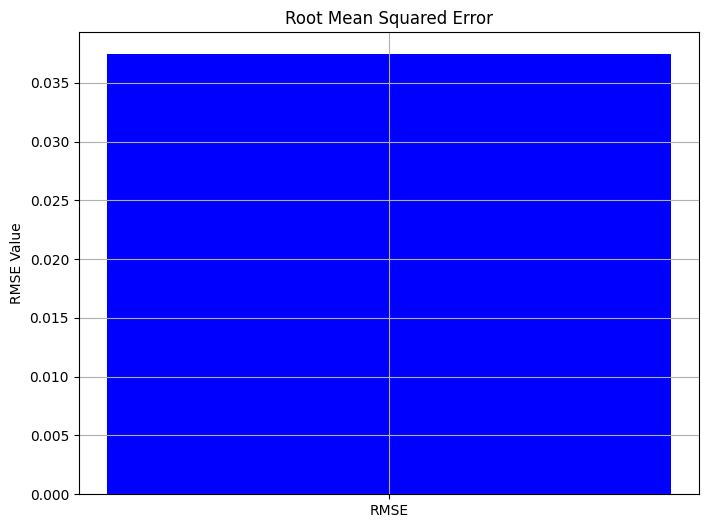

RMSE: 0.04


In [ ]:
plot_rmse(y_test_actual, y_pred_actual)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

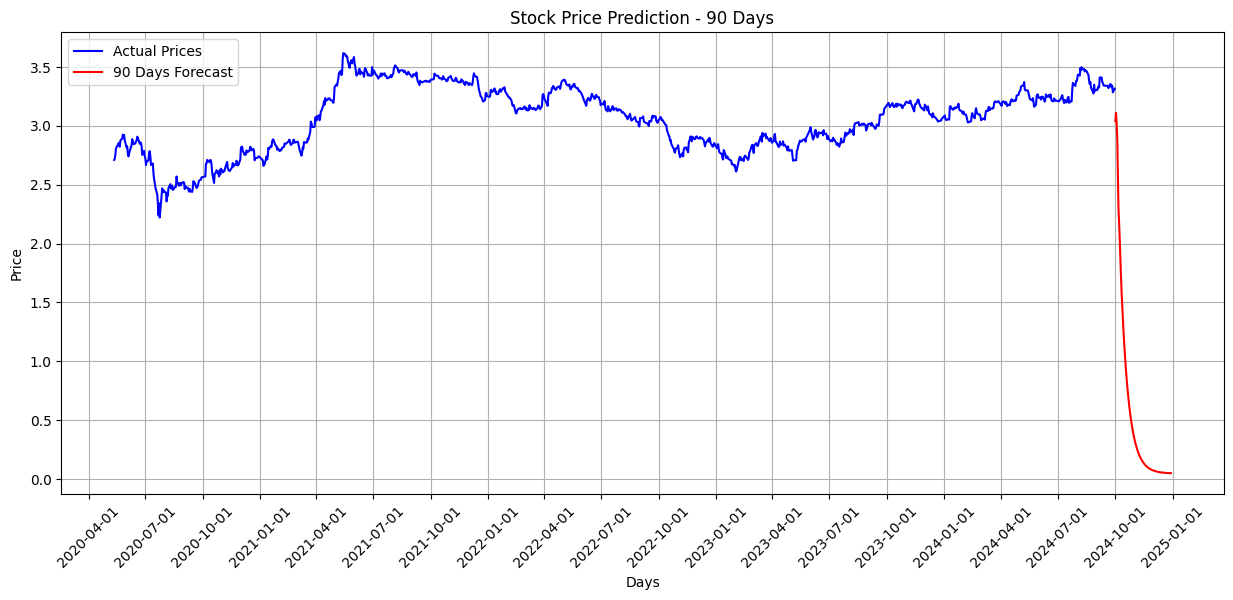

In [ ]:
def predict_future(model, x_test, steps=90):
    """
    미래 예측 수행
    :param model: 학습된 모델
    :param x_test: 테스트 데이터
    :param steps: 예측할 미래의 일수
    :return: 미래 예측값 리스트
    """
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 시퀀스 가져오기

    for i in range(steps):
        # 모델 예측 수행
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # 입력 시퀀스를 업데이트 (shift and append prediction)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1] = prediction

    return np.array(future_predictions)


# y_test를 1D로 변환
y_test = y_test.ravel()

# test_dates 길이를 y_test와 정확히 맞춤
test_dates = same_ddf['Date'][4782:] #same3 이 아니고
test_dates = test_dates[-len(y_test):]  # y_test 길이에 맞춰 슬라이싱

# 미래 날짜 생성
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)

# 미래 예측값 생성
future_90_days = predict_future(model, x_test, steps=90)

# 시각화
plt.figure(figsize=(15, 6))

# 실제 가격 플롯
plt.plot(test_dates, y_test[:len(test_dates)], label='Actual Prices', color='blue')

# 90일 예측 플롯
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')

# 플롯 설정
plt.title('Stock Price Prediction - 90 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')

# 날짜 포맷팅 및 틱 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/

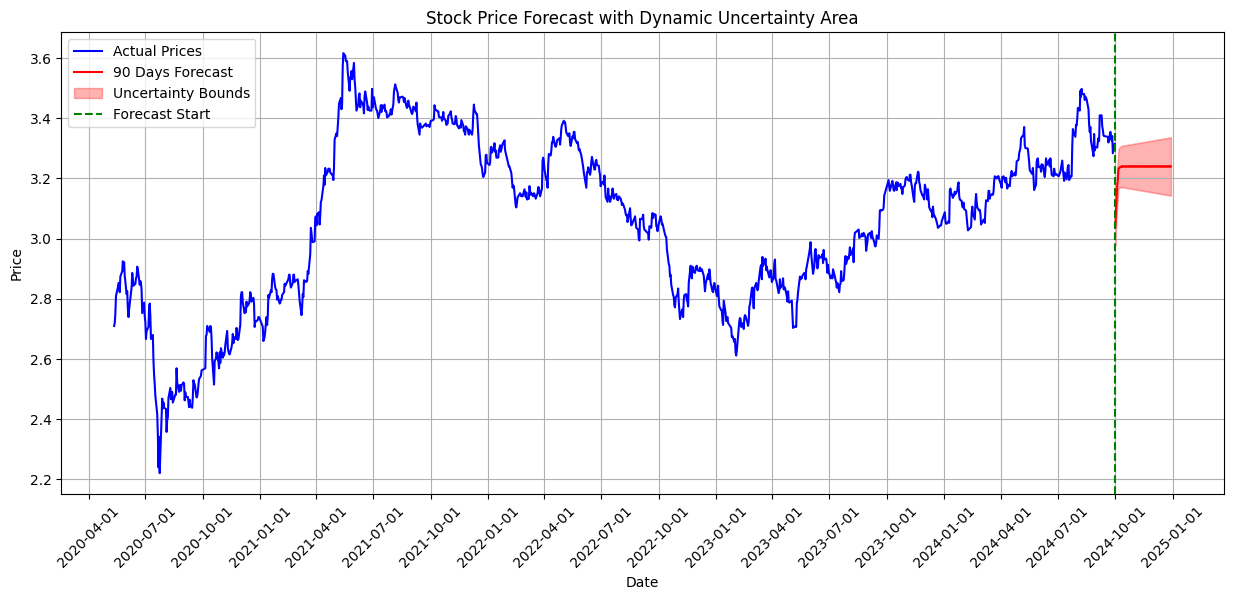

In [ ]:
def predict_future_with_bounds(model, x_test, steps=90):
    """
    미래 예측 수행 및 상한/하한 계산
    :param model: 학습된 모델
    :param x_test: 테스트 데이터
    :param steps: 예측할 미래의 일수
    :return: 미래 예측값, 상한, 하한
    """
    future_predictions = []
    upper_bounds = []
    lower_bounds = []

    current_input = x_test[-1:]  # 마지막 시퀀스 가져오기

    for i in range(steps):
        # 모델 예측 수행
        prediction = model.predict(current_input)[0, 0]

        # 불확실성 계산
        uncertainty = 0.02 + 0.01 * i / steps  # 불확실성 증가

        upper_bound = prediction * (1 + uncertainty)
        lower_bound = prediction * (1 - uncertainty)

        future_predictions.append(prediction)
        upper_bounds.append(upper_bound)
        lower_bounds.append(lower_bound)

        # 현재 입력 업데이트 (shift and append prediction)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return (
        np.array(future_predictions),
        np.array(upper_bounds),
        np.array(lower_bounds),
    )


# 테스트 날짜와 y_test 길이 맞춤
test_dates = same_ddf['Date'][4782:]
y_test = y_test.ravel()
test_dates = test_dates[-len(y_test):]

# 미래 날짜 생성
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)

# 90일 미래 예측 수행
future_90_days, upper_90_days, lower_90_days = predict_future_with_bounds(model, x_test, steps=90)

# 시각화
plt.figure(figsize=(15, 6))

# 실제 주식 가격
plt.plot(test_dates, y_test[:len(test_dates)], label="Actual Prices", color="blue")

# 90일 예측 및 불확실성 영역
plt.plot(future_dates, future_90_days, label="90 Days Forecast", color="red")
plt.fill_between(
    future_dates,
    upper_90_days,
    lower_90_days,
    color="red",
    alpha=0.3,
    label="Uncertainty Bounds",
)

# 예측 시작점 표시
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color="green", linestyle="--", label="Forecast Start")

# 플롯 설정
plt.title("Stock Price Forecast with Dynamic Uncertainty Area")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 

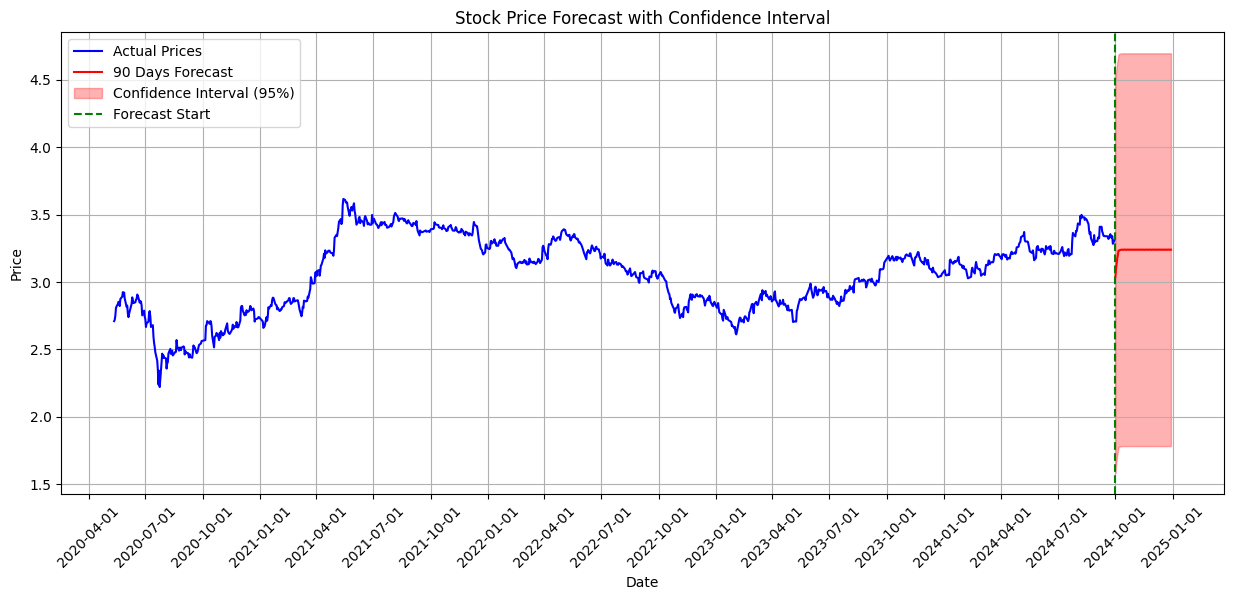

In [ ]:
def predict_future_with_confidence(model, x_test, steps=90):
    """
    미래 예측 수행 및 Confidence Interval 계산
    :param model: 학습된 모델
    :param x_test: 테스트 데이터
    :param steps: 예측할 미래의 일수
    :return: 미래 예측값, 상한선, 하한선
    """
    future_predictions = []
    current_input = x_test[-1:]  # 마지막 시퀀스를 가져옵니다

    # 초기 변동성 계산 (기존 데이터의 표준편차 사용)
    std = np.std(x_test[:, :, -1])

    for i in range(steps):
        # 예측 수행
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # 입력 시퀀스 업데이트 (shift and append prediction)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    # Confidence Interval 계산 (95% 신뢰구간)
    future_predictions = np.array(future_predictions)
    upper_bound = future_predictions + 1.96 * std
    lower_bound = future_predictions - 1.96 * std

    return future_predictions, upper_bound, lower_bound


# 테스트 날짜와 y_test 길이 맞춤
test_dates = same_ddf['Date'][4782:]
y_test = y_test.ravel()
test_dates = test_dates[-len(y_test):]

# 미래 날짜 생성
future_dates = pd.date_range(test_dates.iloc[-1] + pd.Timedelta(days=1), periods=90)

# 미래 예측 수행
future_90_days, upper_90_days, lower_90_days = predict_future_with_confidence(model, x_test, steps=90)

# 시각화
plt.figure(figsize=(15, 6))

# 실제 가격
plt.plot(test_dates, y_test[:len(test_dates)], label="Actual Prices", color="blue")

# 예측값과 Confidence Interval
plt.plot(future_dates, future_90_days, label="90 Days Forecast", color="red")
plt.fill_between(
    future_dates,
    upper_90_days,
    lower_90_days,
    color="red",
    alpha=0.3,
    label="Confidence Interval (95%)",
)

# 예측 시작점 표시
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color="green", linestyle="--", label="Forecast Start")

# 플롯 설정
plt.title("Stock Price Forecast with Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

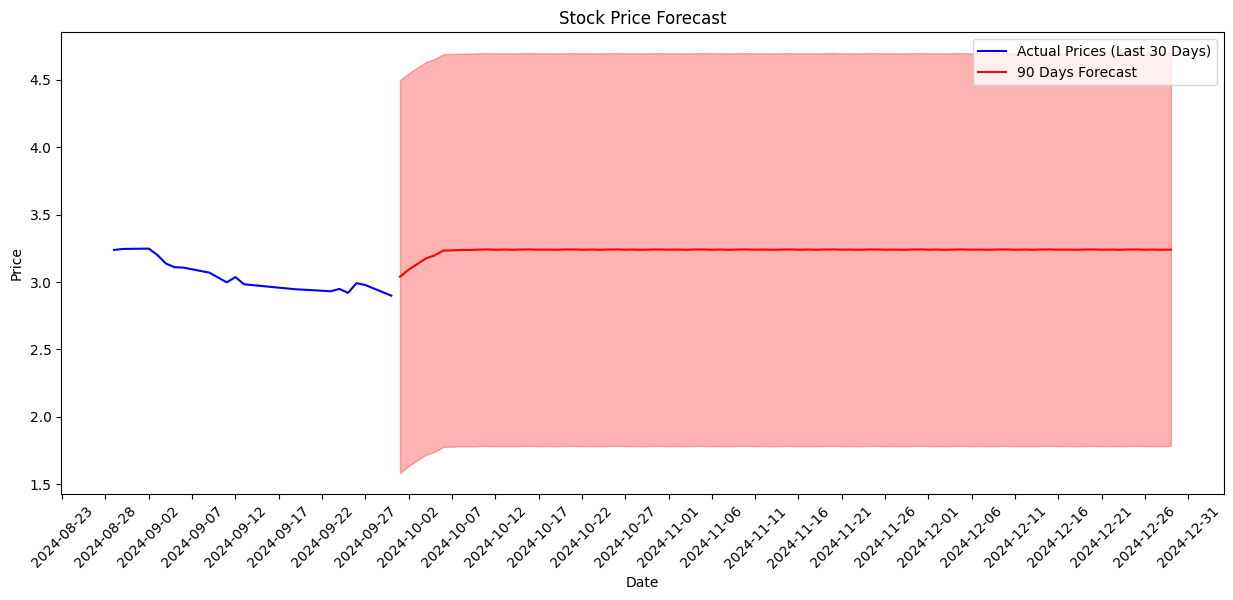

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
#plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━

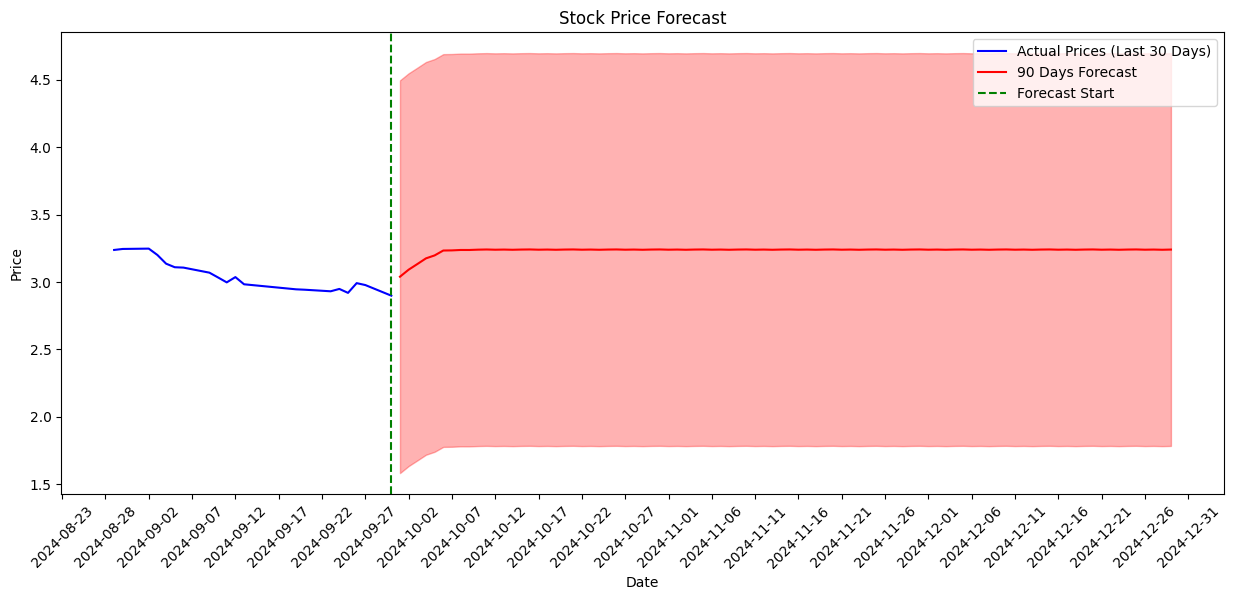

In [ ]:
def predict_future_confidence(model, x_test, steps=90, feature_generator=None):
    future_predictions = []
    current_input = x_test[-1:]

    for i in range(steps):
        prediction = model.predict(current_input)[0, 0]
        future_predictions.append(prediction)

        # Confidence Interval 계산 (표준편차 기반)
        if i == 0:
            std = np.std(x_test[:, :, -1])  # 과거 데이터 기반 변동성 계산
        upper_bound = np.array(future_predictions) + 1.96 * std  # 95% Confidence Interval 상한선
        lower_bound = np.array(future_predictions) - 1.96 * std  # 95% Confidence Interval 하한선

        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, -1] = prediction

    return np.array(future_predictions), upper_bound, lower_bound

future_90_days, upper_90_days, lower_90_days = predict_future_confidence(model, x_test, steps=90, feature_generator=feature_generator)

plt.figure(figsize=(15, 6))
plt.plot(test_dates[-20:], y_test[-20:], label='Actual Prices (Last 30 Days)', color='blue')
plt.plot(future_dates, future_90_days, label='90 Days Forecast', color='red')
plt.fill_between(future_dates, upper_90_days, lower_90_days, color='red', alpha=0.3)
forecast_start_date = test_dates.iloc[-1]
plt.axvline(x=forecast_start_date, color='green', linestyle='--', label='Forecast Start')

plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def evaluate_model(model, x_data, y_data, threshold=0.5):
    """
    모델 평가 함수: PR Curve, AUC-ROC, RMSE 계산
    :param model: 훈련된 모델
    :param x_data: 입력 데이터
    :param y_data: 실제 값
    :param threshold: 이진화 기준값
    :return: AUC, PR Curve, RMSE
    """
    predictions = model.predict(x_data).flatten()

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_data, predictions))

    # 임계값 기반으로 예측 값 이진화
    binary_preds = (predictions >= threshold).astype(int)
    binary_true = (y_data >= threshold).astype(int)

    # PR Curve와 AUC-ROC 계산
    precision, recall, _ = precision_recall_curve(binary_true, predictions)
    auc_roc = roc_auc_score(binary_true, predictions)

    return precision, recall, auc_roc, rmse, predictions

In [ ]:
def plot_pr_curve(precision, recall, label="PR Curve"):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [ ]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

In [ ]:
def plot_predictions(y_true, y_pred, title="Prediction vs Actual"):
    plt.figure(figsize=(8, 6))
    plt.plot(y_true, label="Actual", alpha=0.7)
    plt.plot(y_pred, label="Predicted", alpha=0.7)
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def train_model(x_train, y_train, x_val, y_val, x_test, y_test,
                num_heads=4, key_dim=64, ff_dim=128, num_blocks=2, dropout_rate=0.2,
                initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.96, staircase=True,
                epochs=200, batch_size=32):
    # 학습률 스케줄링
    lrs = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=staircase
    )

    # 모델 생성 및 컴파일
    input_shape = (x_train.shape[1], x_train.shape[2])
    model = build_transformer_model(input_shape, num_heads, key_dim, ff_dim, num_blocks, dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrs),
                  loss="mse",
                  metrics=["mae"])

    # 모델 훈련
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
    )
    return history, model

In [ ]:
def evaluate_and_visualize_all(model, x_train, y_train, x_val, y_val, x_test, y_test, history):
    """
    Train, Validation, Test 데이터셋 평가 및 시각화
    """
    # Train 데이터 평가
    precision_train, recall_train, auc_roc_train, rmse_train, pred_train = evaluate_model(model, x_train, y_train)
    print(f"Train AUC-ROC: {auc_roc_train:.4f}, RMSE: {rmse_train:.4f}")

    # Validation 데이터 평가
    precision_val, recall_val, auc_roc_val, rmse_val, pred_val = evaluate_model(model, x_val, y_val)
    print(f"Validation AUC-ROC: {auc_roc_val:.4f}, RMSE: {rmse_val:.4f}")

    # Test 데이터 평가
    precision_test, recall_test, auc_roc_test, rmse_test, pred_test = evaluate_model(model, x_test, y_test)
    print(f"Test AUC-ROC: {auc_roc_test:.4f}, RMSE: {rmse_test:.4f}")

    # PR Curve 시각화
    plot_pr_curve(precision_train, recall_train, label="Train PR Curve")
    plot_pr_curve(precision_val, recall_val, label="Validation PR Curve")
    plot_pr_curve(precision_test, recall_test, label="Test PR Curve")

    # Loss Curve 시각화
    plot_loss(history)

    # Prediction vs Actual 시각화
    plot_predictions(y_train, pred_train, title="Train Data: Prediction vs Actual")
    plot_predictions(y_val, pred_val, title="Validation Data: Prediction vs Actual")
    plot_predictions(y_test, pred_test, title="Test Data: Prediction vs Actual")


In [ ]:
history, model = train_model(
    x_train, y_train, x_val, y_val, x_test, y_test,
    num_heads=4, key_dim=64, ff_dim=128, num_blocks=3, dropout_rate=0.2,
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.96,
    epochs=200, batch_size=32
)

Epoch 1/200
110/110 - 18s - 164ms/step - loss: 0.4769 - mae: 0.4605 - val_loss: 0.1379 - val_mae: 0.2691
Epoch 2/200
110/110 - 5s - 41ms/step - loss: 0.0780 - mae: 0.2236 - val_loss: 0.1175 - val_mae: 0.2670
Epoch 3/200
110/110 - 6s - 51ms/step - loss: 0.0545 - mae: 0.1853 - val_loss: 0.1339 - val_mae: 0.2576
Epoch 4/200
110/110 - 4s - 37ms/step - loss: 0.0381 - mae: 0.1544 - val_loss: 0.2104 - val_mae: 0.3654
Epoch 5/200
110/110 - 6s - 55ms/step - loss: 0.0306 - mae: 0.1389 - val_loss: 0.1018 - val_mae: 0.2023
Epoch 6/200
110/110 - 5s - 49ms/step - loss: 0.0236 - mae: 0.1220 - val_loss: 0.1223 - val_mae: 0.2463
Epoch 7/200
110/110 - 11s - 103ms/step - loss: 0.0200 - mae: 0.1117 - val_loss: 0.1164 - val_mae: 0.2548
Epoch 8/200
110/110 - 8s - 70ms/step - loss: 0.0176 - mae: 0.1043 - val_loss: 0.0973 - val_mae: 0.1964
Epoch 9/200
110/110 - 4s - 34ms/step - loss: 0.0159 - mae: 0.0995 - val_loss: 0.1037 - val_mae: 0.2215
Epoch 10/200
110/110 - 6s - 56ms/step - loss: 0.0148 - mae: 0.0964 - 

In [ ]:
evaluate_and_visualize_all(model, x_train, y_train, x_val, y_val, x_test, y_test, history)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Train AUC-ROC: 0.9991, RMSE: 0.0180
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

### 1

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.5591 - mae: 0.5588 - val_loss: 0.1336 - val_mae: 0.3384
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0468 - mae: 0.1718 - val_loss: 0.0719 - val_mae: 0.2273
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169 - mae: 0.1034 - val_loss: 0.0529 - val_mae: 0.1898
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - mae: 0.0761 - val_loss: 0.0711 - val_mae: 0.2335
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0074 - mae: 0.0680 - val_loss: 0.0454 - val_mae: 0.1779
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065 - mae: 0.0638 - val_loss: 0.0366 - val_mae: 0.1602
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0638 - val_loss: 0.0316 - val_mae: 0.1518
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0629 - val_loss: 0.0562 - val_mae: 0.2017
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

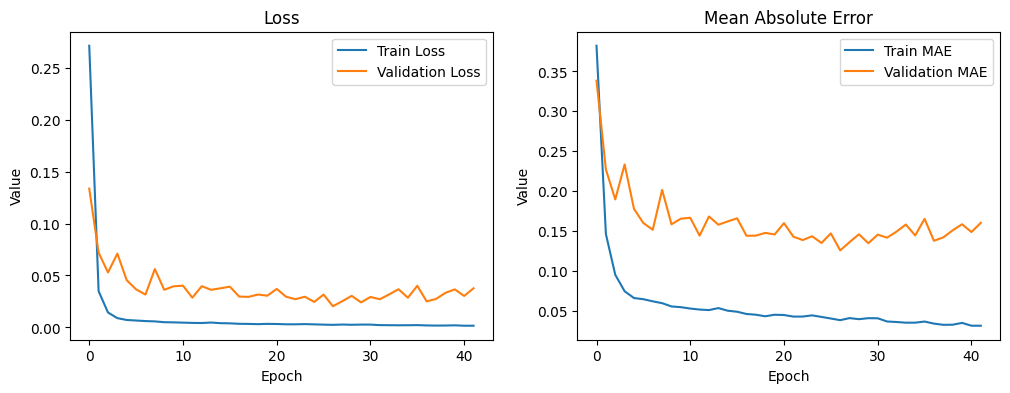

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error (MAE): 0.7838505811054073
Root Mean Squared Error (RMSE): 0.8022740240408099


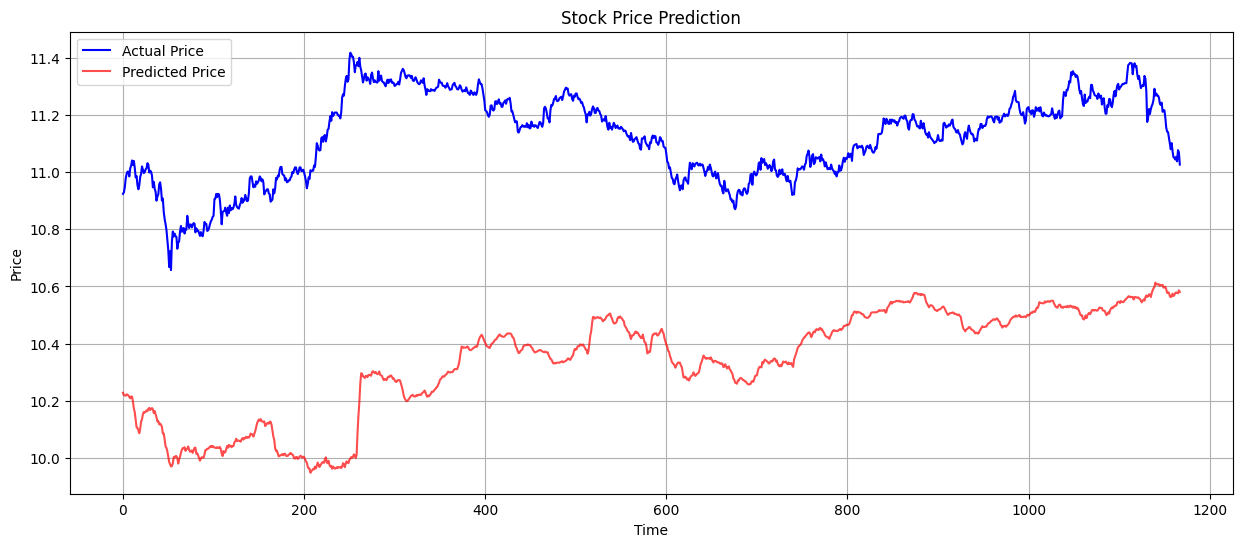

In [ ]:
y_pred = model.predict(x_test)

# 스케일 복원
y_test_actual = y_scaler.inverse_transform(y_test)
y_pred_actual = y_scaler.inverse_transform(y_pred)

# 오차 계산
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


# 그래프 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label="Actual Price", color="b")
plt.plot(y_pred_actual, label="Predicted Price", color="r", alpha=0.7)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()


### 2

In [ ]:
# Best Hyperparameters:
# Number of Transformer Blocks: 2
# Number of Attention Heads: 2
# Key Dimension Size: 128
# Feed-Forward Dim: 192
# Dropout Rate: 0.2
# Initial Learning Rate: 8.217112505860899e-05

x_train, y_train = create_sequences(x_train_same3, y_train_same3, seq_length)
x_val, y_val = create_sequences(x_val_same3, y_val_same3, seq_length)
x_test, y_test = create_sequences(x_test_same3, y_test_same3, seq_length)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=300,
    batch_size=32,
    #callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0010 - mae: 0.0236 - val_loss: 0.0144 - val_mae: 0.1016
Epoch 2/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.5876e-04 - mae: 0.0229 - val_loss: 0.0122 - val_mae: 0.0932
Epoch 3/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0082 - val_mae: 0.0798
Epoch 4/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0010 - mae: 0.0233 - val_loss: 0.0106 - val_mae: 0.0870
Epoch 5/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.9464e-04 - mae: 0.0229 - val_loss: 0.0098 - val_mae: 0.0840
Epoch 6/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.5656e-04 - mae: 0.0225 - val_loss: 0.0102 - val_mae: 0.0856
Epoch 7/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 9.5157e-04 - mae: 0.0227 - val_loss: 0.0094 - val_mae: 0.0831
Epoch 8/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.0993e-04 - mae: 0.0223 - val_loss: 0.0146 - val_mae: 0.1030
Epoch 9/300
110/110 

KeyboardInterrupt: 

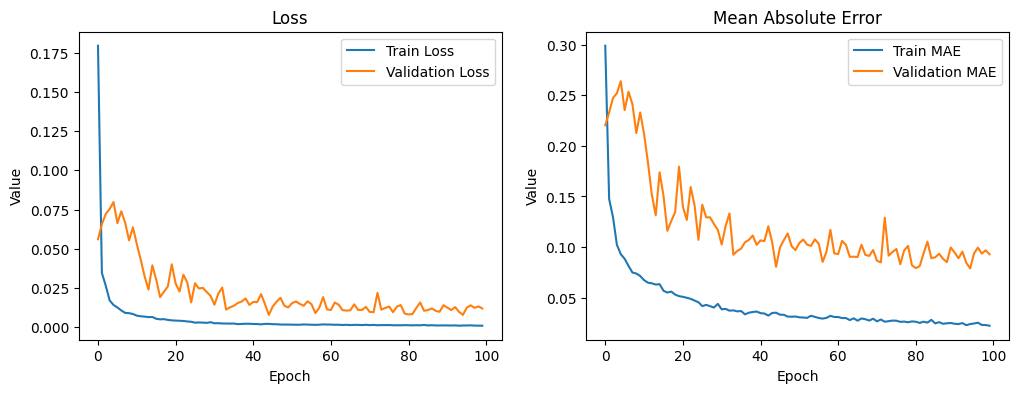

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error (MAE): 0.8509779909685526
Root Mean Squared Error (RMSE): 0.8619285547071226


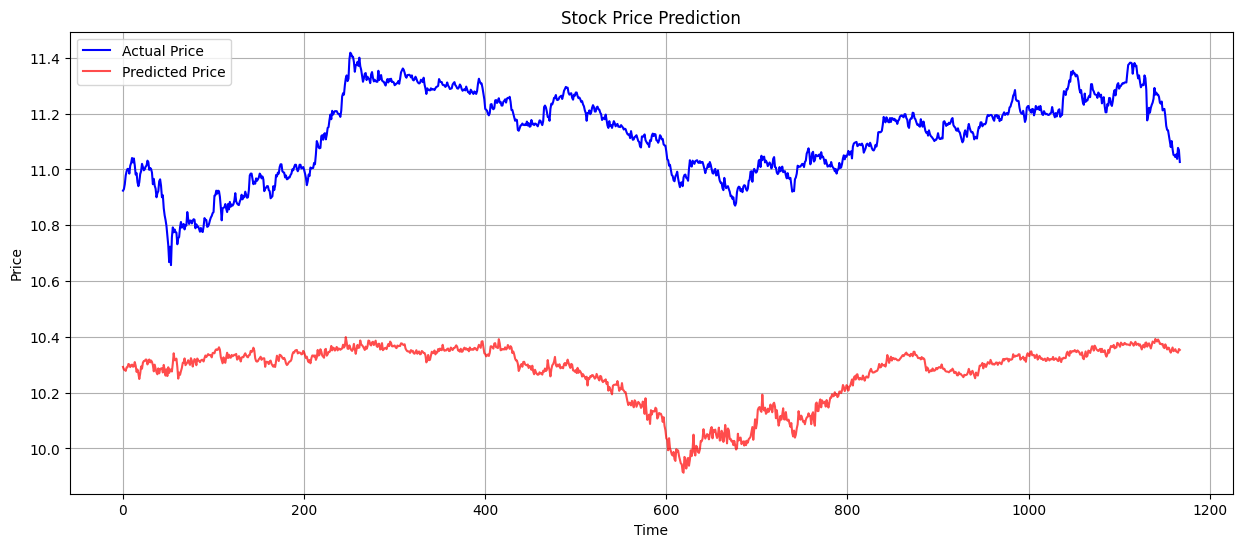

In [ ]:
y_pred = model.predict(x_test)

# 스케일 복원
y_test_actual = y_scaler.inverse_transform(y_test)
y_pred_actual = y_scaler.inverse_transform(y_pred)

# 오차 계산
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


# 그래프 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label="Actual Price", color="b")
plt.plot(y_pred_actual, label="Predicted Price", color="r", alpha=0.7)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()


# 하이퍼파라미터 튜닝

In [ ]:
!pip install keras_tuner

In [ ]:
import keras_tuner as kt

#이거 그대로 하면 터져서, 조정해야함

def build_transformer_model(hp):
    input_shape = (seq_length, x_train.shape[-1])
    inputs = layers.Input(shape=input_shape)
    x = PositionalEncoding(sequence_length=seq_length, d_model=x_train.shape[-1])(inputs)

    num_blocks = hp.Int('num_blocks', min_value=2, max_value=3, step=1)
    num_heads = hp.Choice('num_heads', values=[2, 4, 8])
    key_dim = hp.Int('key_dim', min_value=32, max_value=128, step=32)
    ff_dim = hp.Int('ff_dim', min_value=64, max_value=256, step=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    initial_learning_rate = hp.Float('initial_learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")

    for _ in range(num_blocks):
        x = transformer_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout_rate=dropout_rate)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = tf.keras.Model(inputs, outputs)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model

# Keras Tuner를 실행하여 하이퍼파라미터 튜닝
def run_tuner():
    tuner = kt.Hyperband(
        build_transformer_model,
        objective='val_loss',
        max_epochs=20,
        factor=3,
        directory='tuner_dir',
        project_name='transformer_tuning'
    )

    # 데이터로 모델 학습 및 튜닝 수행
    tuner.search(x_train, y_train, validation_split=0.2, batch_size=32)

    # 최적의 하이퍼파라미터 탐색 결과 출력
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best Hyperparameters:")
    print(f"Number of Transformer Blocks: {best_hps.get('num_blocks')}")
    print(f"Number of Attention Heads: {best_hps.get('num_heads')}")
    print(f"Key Dimension Size: {best_hps.get('key_dim')}")
    print(f"Feed-Forward Dim: {best_hps.get('ff_dim')}")
    print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
    print(f"Initial Learning Rate: {best_hps.get('initial_learning_rate')}")

    model = tuner.hypermodel.build(best_hps)
    model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=32)

run_tuner()

Trial 30 Complete [00h 00m 34s]
val_loss: 0.0005677847075276077

Best val_loss So Far: 0.00043878998258151114
Total elapsed time: 00h 17m 33s
Best Hyperparameters:
Number of Transformer Blocks: 2
Number of Attention Heads: 2
Key Dimension Size: 128
Feed-Forward Dim: 192
Dropout Rate: 0.2
Initial Learning Rate: 8.217112505860899e-05
Epoch 1/20
